In [1]:
# import libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapboxTiles
import geopandas as gpd
import random

In [2]:
# set user dir (WIP)
# user_dir = "/Users/ls/Dropbox (MIT)/02 Work/LCAU:SERC/Million Neighborhoods:DP/Data"

In [2]:
# load parcel and building data
# df_parcels = gpd.read_file("/Users/ls/Dropbox (MIT)/02 Work/LCAU:SERC/Million Neighborhoods:DP/Data/Parcels/NYC_2021_Tax_Parcels_SHP_2203/NewYork_2021_Tax_Parcels_SHP_2203.shp")
# df_buildings = gpd.read_file("/Users/ls/Dropbox (MIT)/02 Work/LCAU:SERC/Million Neighborhoods:DP/Data/Building Footprints/NYC/geo_export_a80ea1a2-e8e0-4ffd-862c-1199433ac303.shp")

df_parcels = gpd.read_file("data/NewYork_2021_Tax_Parcels_SHP_2203.shp")
df_buildings = gpd.read_file("data/geo_export_a80ea1a2-e8e0-4ffd-862c-1199433ac303.shp")

In [14]:
# set random RGB color for the parcels
def random_hex_color():
  r = random.randint(0, 255)
  g = random.randint(0, 255)
  b = random.randint(0, 255)
  return "#{:02x}{:02x}{:02x}".format(r, g, b)
random_hex_color()
df_parcels['color'] = [ random_hex_color() for i in range(len(df_parcels)) ]

In [15]:
df_parcels.crs = {'init': 'epsg:26918'}
df_buildings.crs = {'init': 'epsg:4326'}
# WGS84dd = {'init': 'epsg:4326'}

/home/demircantas/anaconda3/envs/VAE2/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
# set CRS to web mercator
df_parcels = df_parcels.to_crs(epsg=3857)
df_buildings = df_buildings.to_crs(epsg=3857)

In [21]:

def add_parcels(ax, df_parcels, crs_epsg):
    # loop through the parcels and plot them
    for row in df_parcels.itertuples():
        geometry = row.geometry
        color = row.color
        ax.add_geometries(geometry, crs = crs_epsg, facecolor=color) # for Lat/Lon data.

In [27]:
# load the background map and plot the geometries
# def map_maker(df_parcels, df_buildings, scale=10):
def map_maker(df_parcels, df_buildings, bounds, index, scale=10, feature_type='both'):
    access_token = "pk.eyJ1IjoiZGVtaXJjYW50YXMiLCJhIjoiY2xrazNudjIzMDA5NjNvcG1lOHZuanVjMSJ9._t6VB8FA4_VAyJOJ9b92jQ"
    tiler = MapboxTiles(access_token, 'satellite-v9')
    crs_epsg = ccrs.epsg('3857')

    mercator = tiler.crs

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=mercator)

    # change figure size of the subplot
    my_dpi=96
    fig.set_size_inches(7, 7)
    # fig.figsize = (512/my_dpi, 512/my_dpi), dpi=my_dpi

    # calculate the centroid and max distance of the bounds
    dist1 = bounds[2]-bounds[0]
    dist2 = bounds[3]-bounds[1]
    max_dist = max(dist1, dist2)/2

    # calculate the centroid of the bounds
    centroid_x = (bounds[2]+bounds[0])/2
    centroid_y = (bounds[3]+bounds[1])/2

    # bounds = df_parcels.total_bounds with offset to create same aspect ratio
    ax.set_extent([centroid_x-max_dist, centroid_x+max_dist, centroid_y-max_dist, centroid_y+max_dist], crs=ccrs.epsg('3857'))

    if feature_type == 'parcels': add_parcels(ax, df_parcels, crs_epsg)
    if feature_type == 'buildings': ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='black', edgecolor='white', linewidth=1.5, alpha=1)
    if feature_type == 'both': 
        add_parcels(ax, df_parcels, crs_epsg)
        ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='black', edgecolor='white', linewidth=1.5, alpha=1)

    # add the Mabox tiles to the axis at zoom level 10 (Mapbox has 23 zoom levels)
    ax.add_image(tiler, scale)

    # set the path to the folder where the images will be saved
    output_folder = 'img/'

    # save the figure
    plt.savefig(output_folder + f'parcel_{index}.jpg', bbox_inches='tight', pad_inches = 0, dpi = my_dpi)

    # close the figure
    plt.close(fig)

    # plt.show()tiler = MapboxTiles(access_token, 'satellite-v9')
    crs_epsg = ccrs.epsg("3857")

    mercator = tiler.crs

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=mercator)
    # change figure size of the subplot
    fig.set_size_inches(18.5, 10.5)

    bounds = df_parcels.total_bounds
    ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], crs=ccrs.epsg("3857"))
    # loop through the parcels and plot them
    for row in df_parcels.itertuples():
        # df_parcels.iloc[i:i+1].plot(color=df_parcels.iloc[i:i+1].color.values[0])
        geometry = row.geometry
        color = row.color
        ax.add_geometries(geometry, crs = crs_epsg, facecolor=color) # for Lat/Lon data.

    ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='black', edgecolor='white', linewidth=1.5, alpha=1)

    # add the Mabox tiles to the axis at zoom level 10 (Mapbox has 23 zoom levels)
    ax.add_image(tiler, scale)

    # ax.coastlines('10m')
    plt.show()

In [28]:
# subset the data frames based on a buffer
def subset(df, df_buildings, index, distance = 75):
    selected_feature = df.loc[index]
    geometry_buffer = selected_feature.geometry.buffer(distance)
    geometry_bounds = selected_feature.geometry.buffer(distance-70)

    return df[df.within(geometry_buffer)], df_buildings[df_buildings.within(geometry_buffer)], geometry_bounds.bounds

In [29]:
# Index will correspond to each of the parcel indices in the data frame. 
# distance is in meters
subset_features = subset(df_parcels, df_buildings, 1999, 200)
map_maker(subset_features[0], subset_features[1], 18)

TypeError: map_maker() missing 1 required positional argument: 'index'

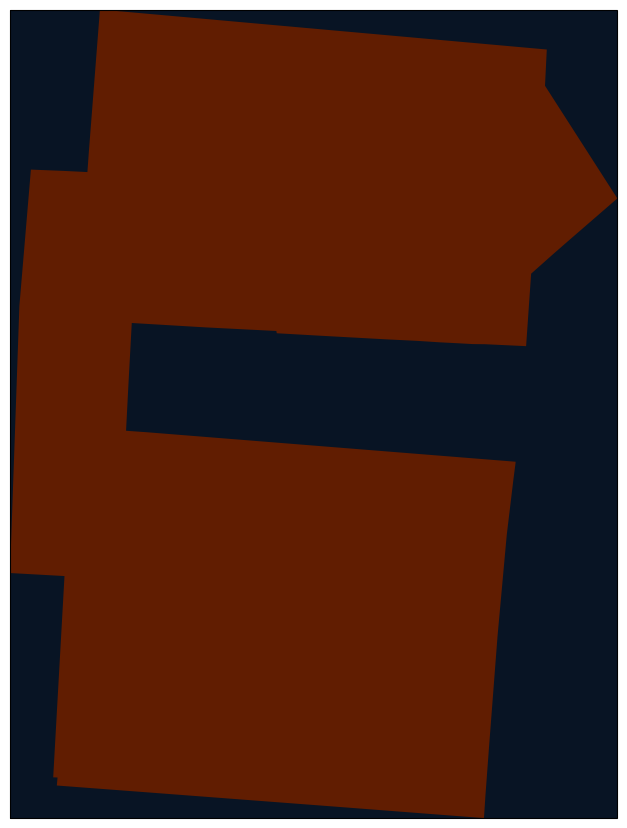

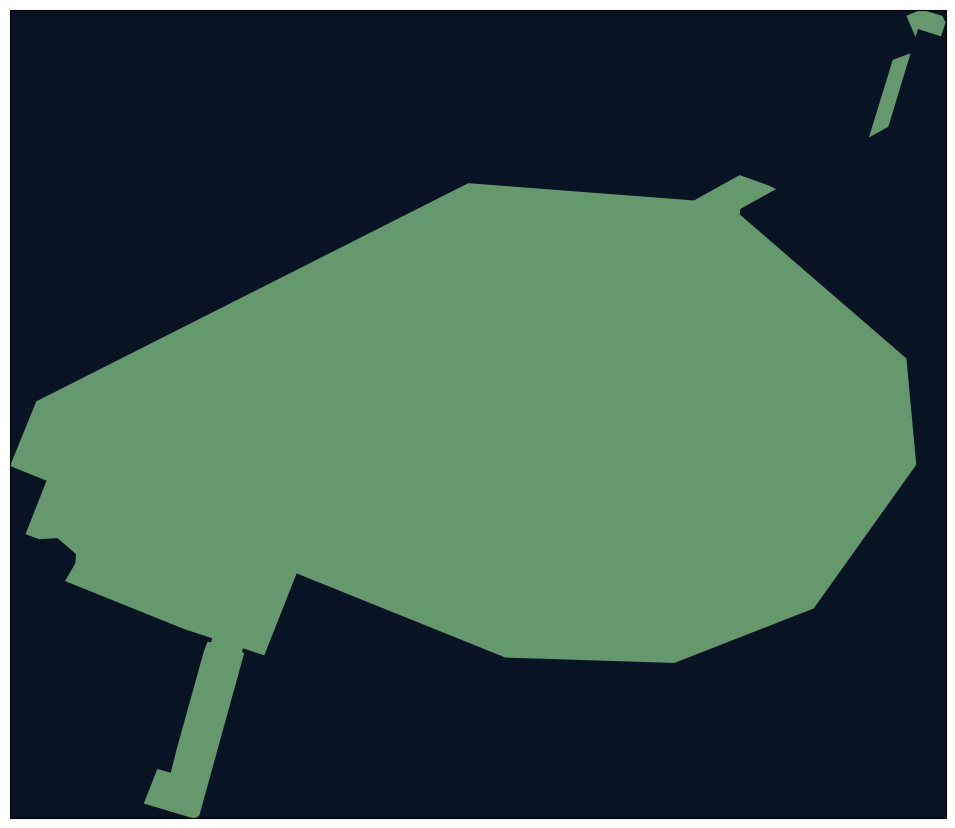

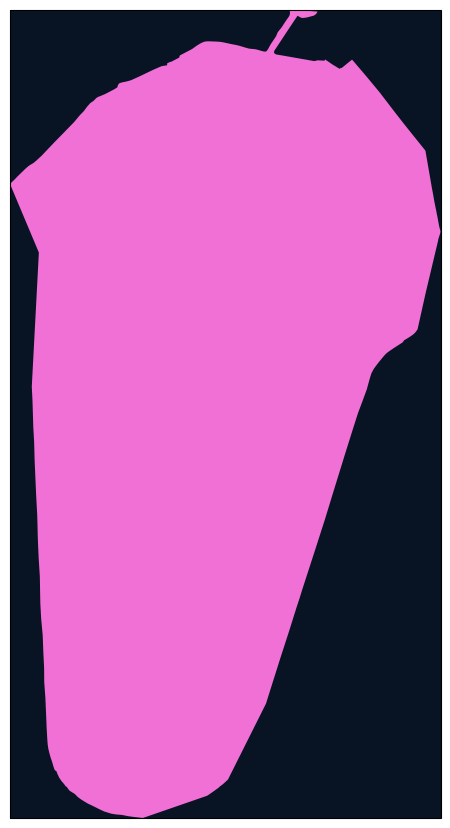

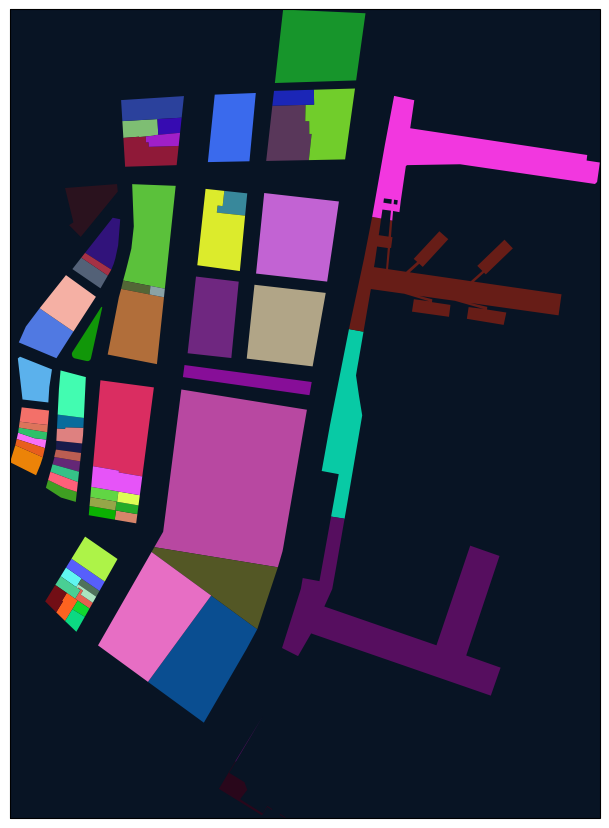

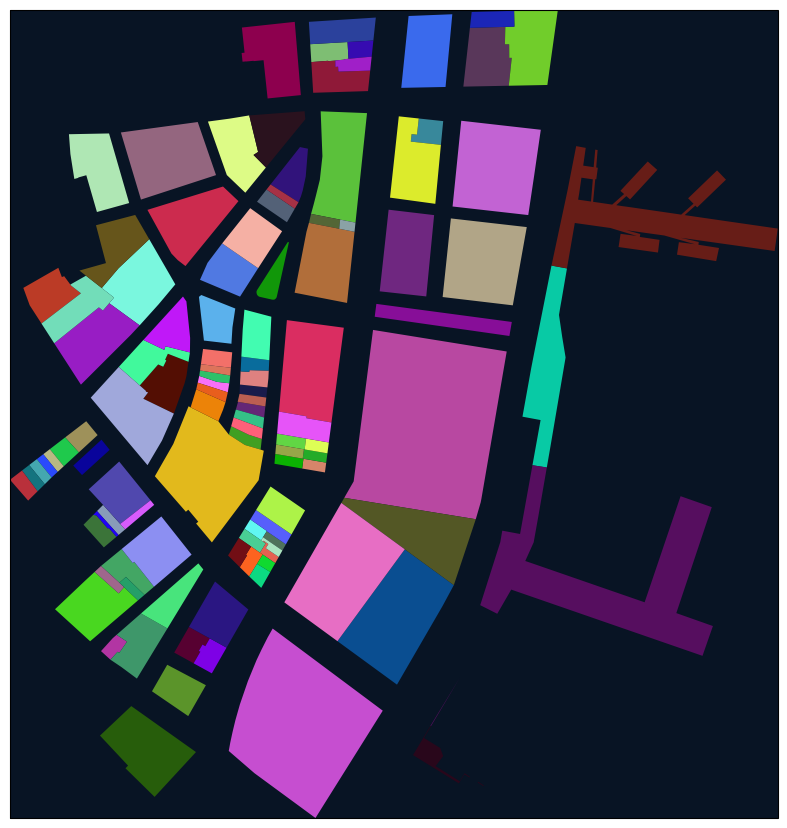

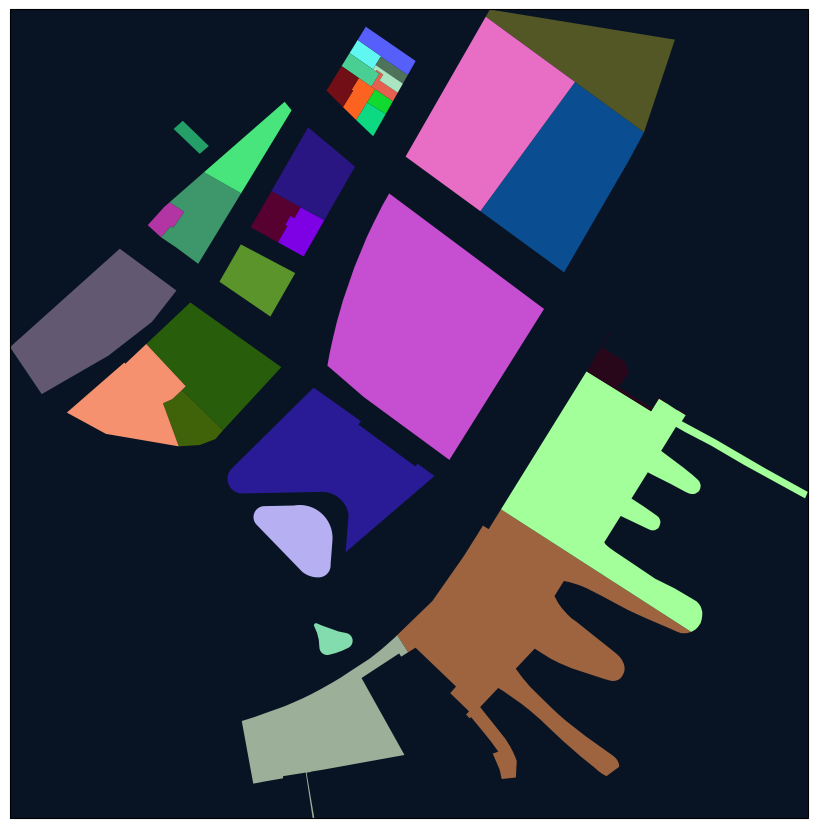

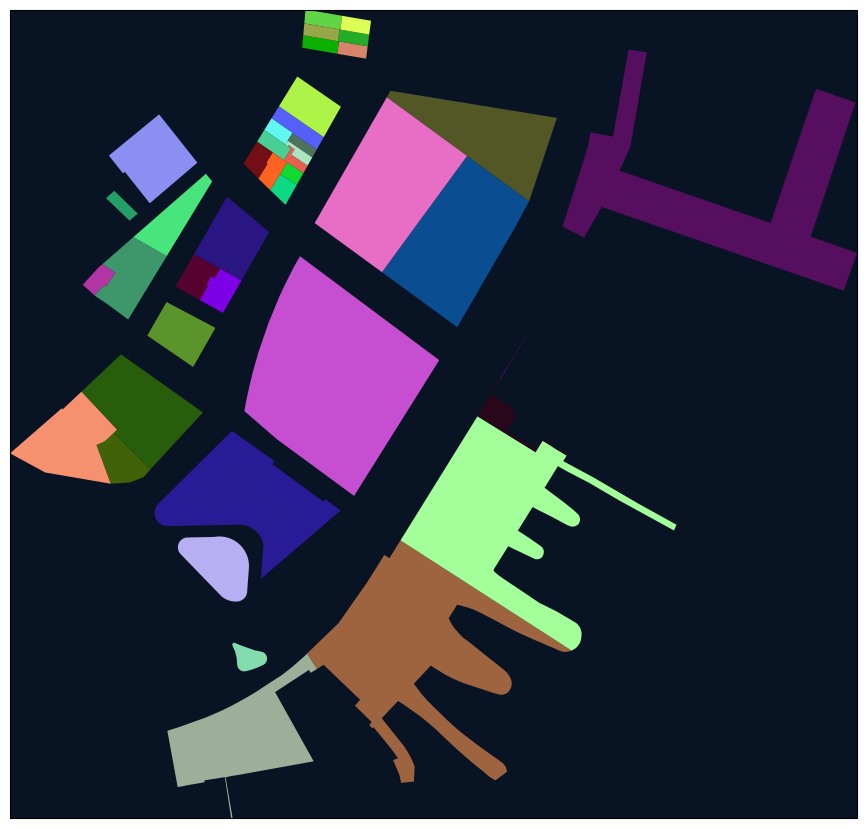

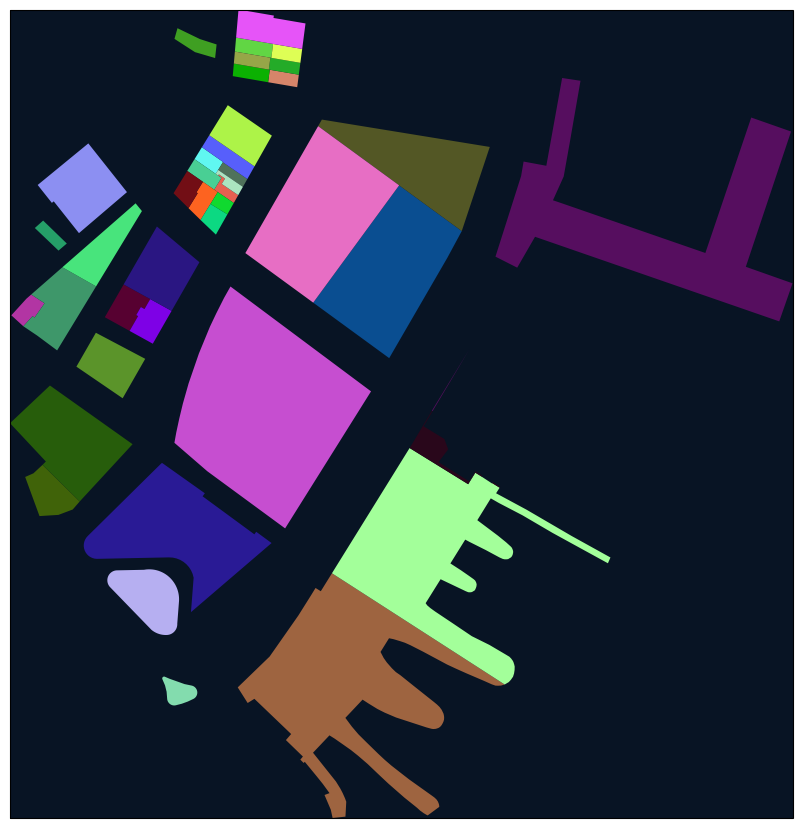

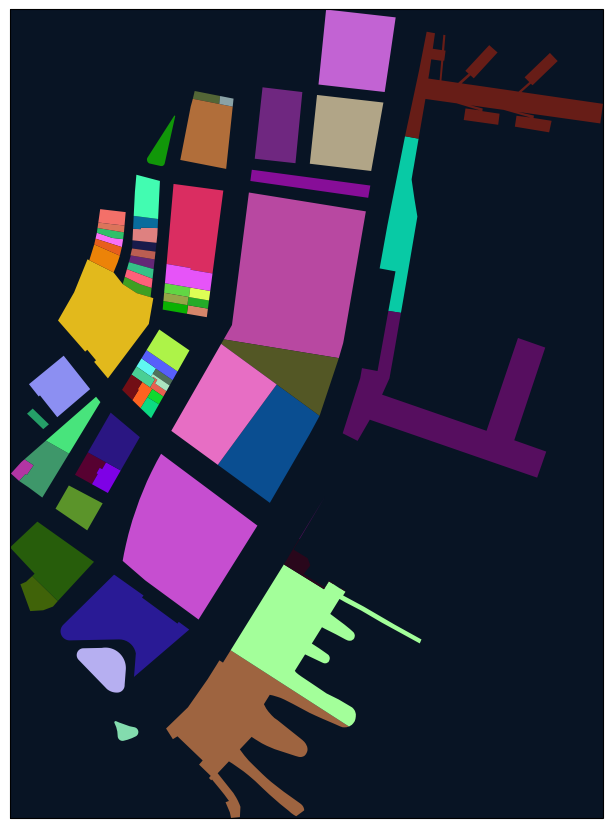

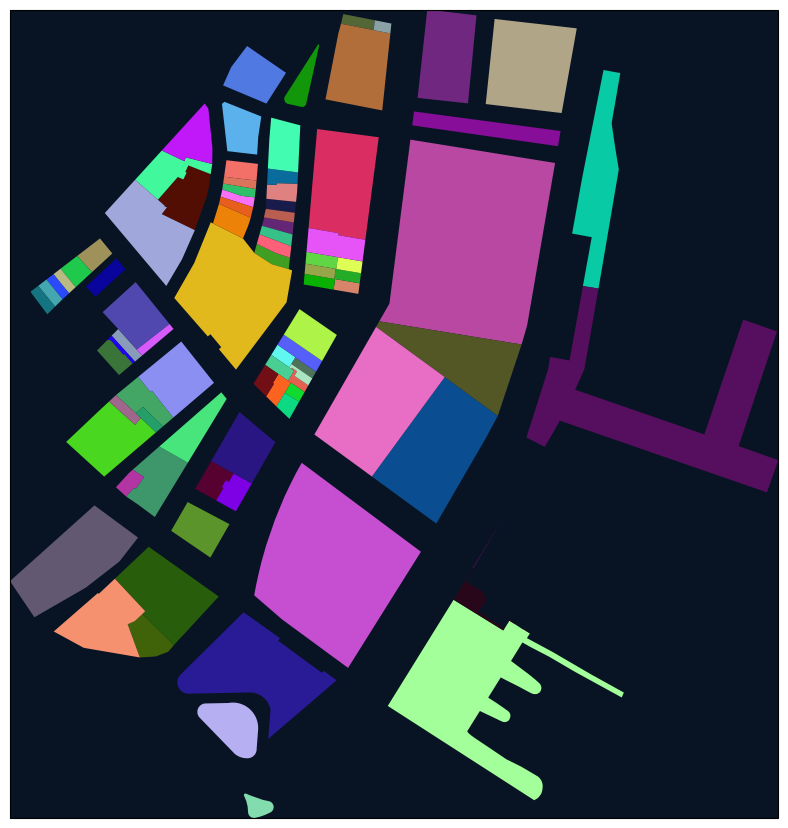

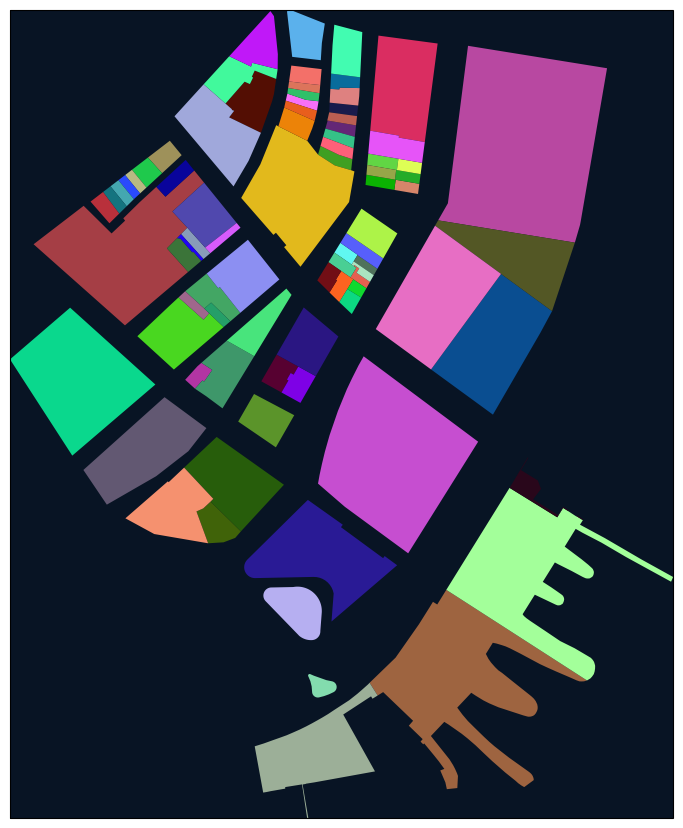

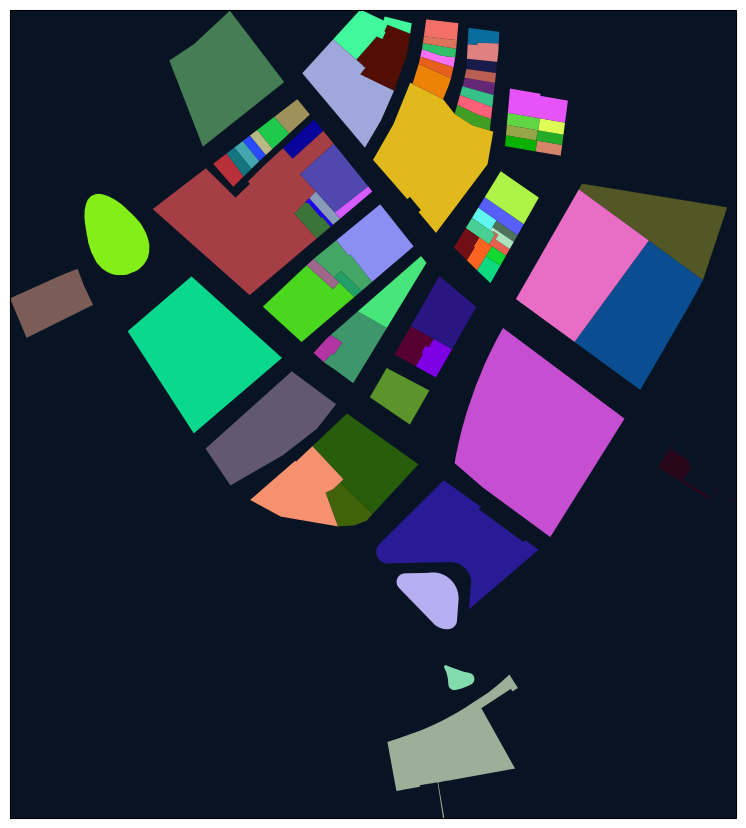

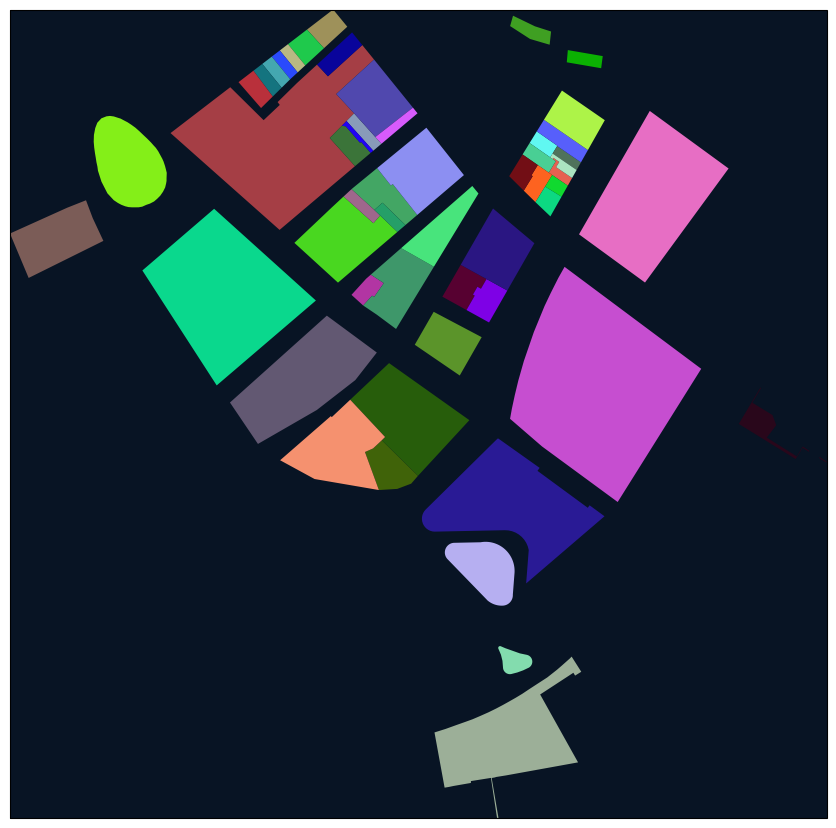

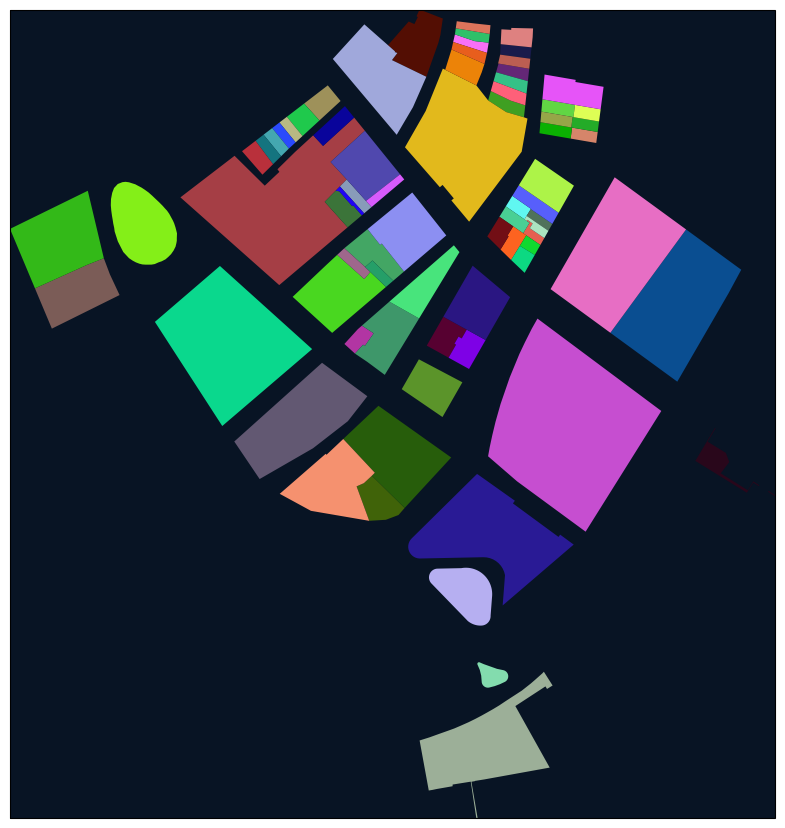

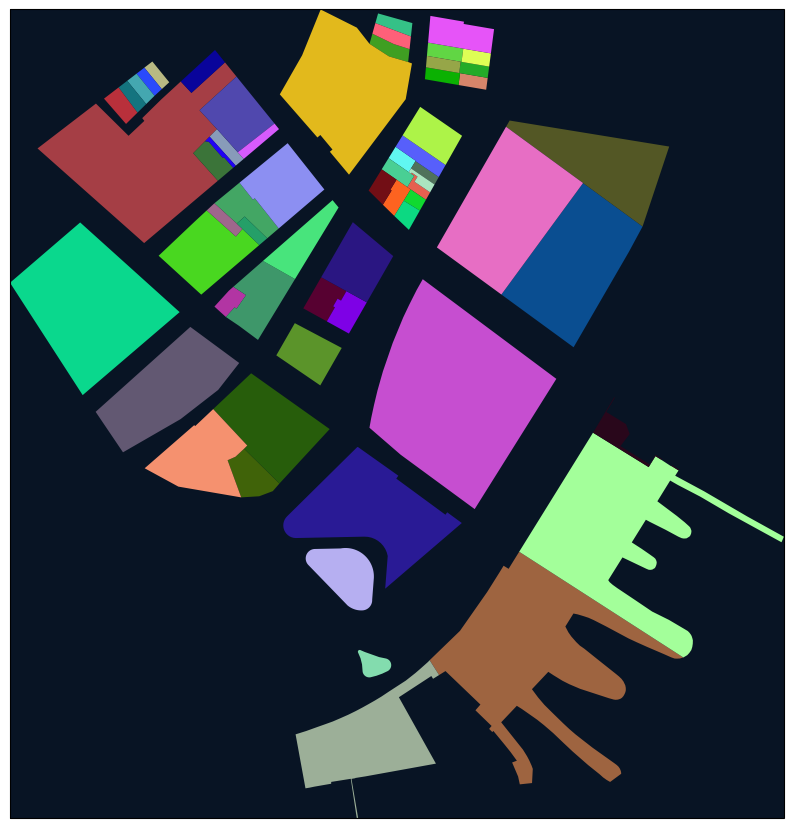

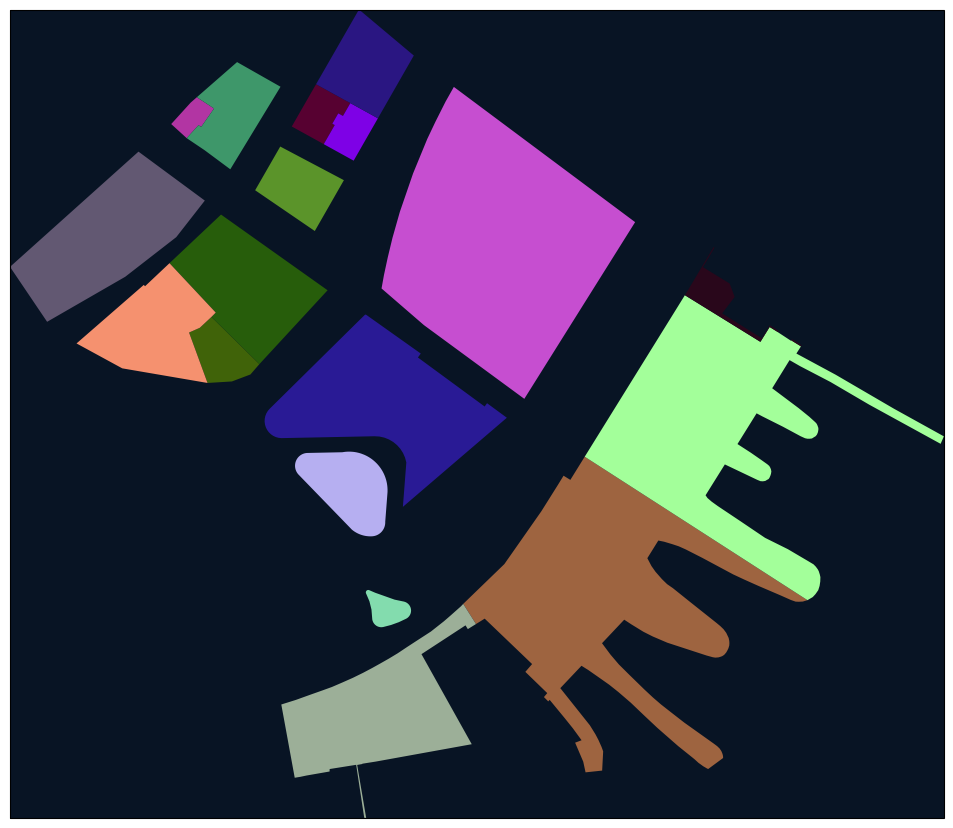

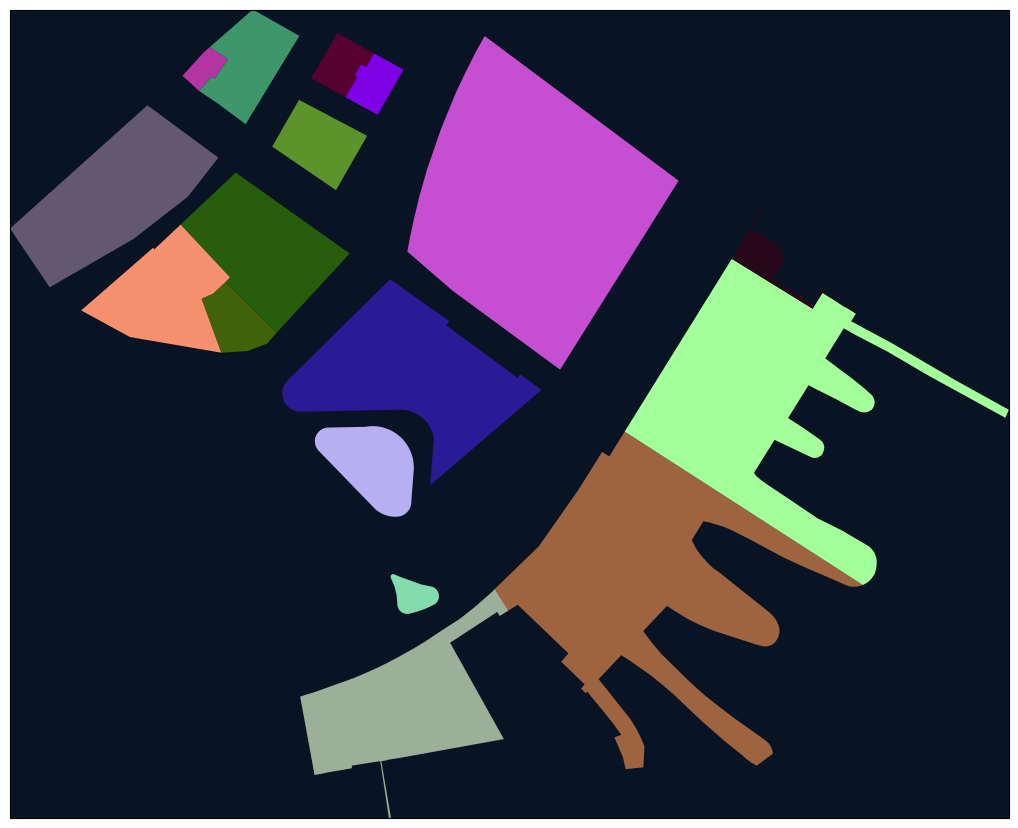

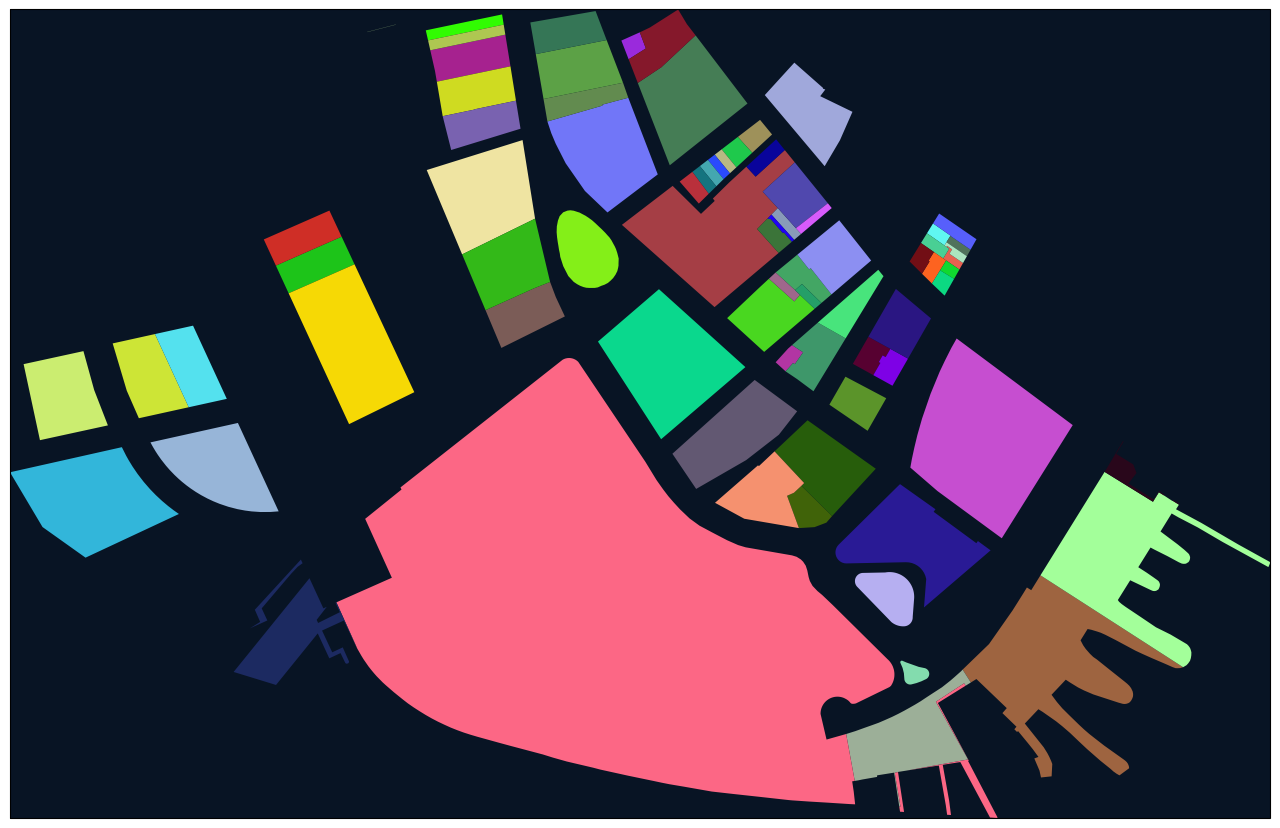

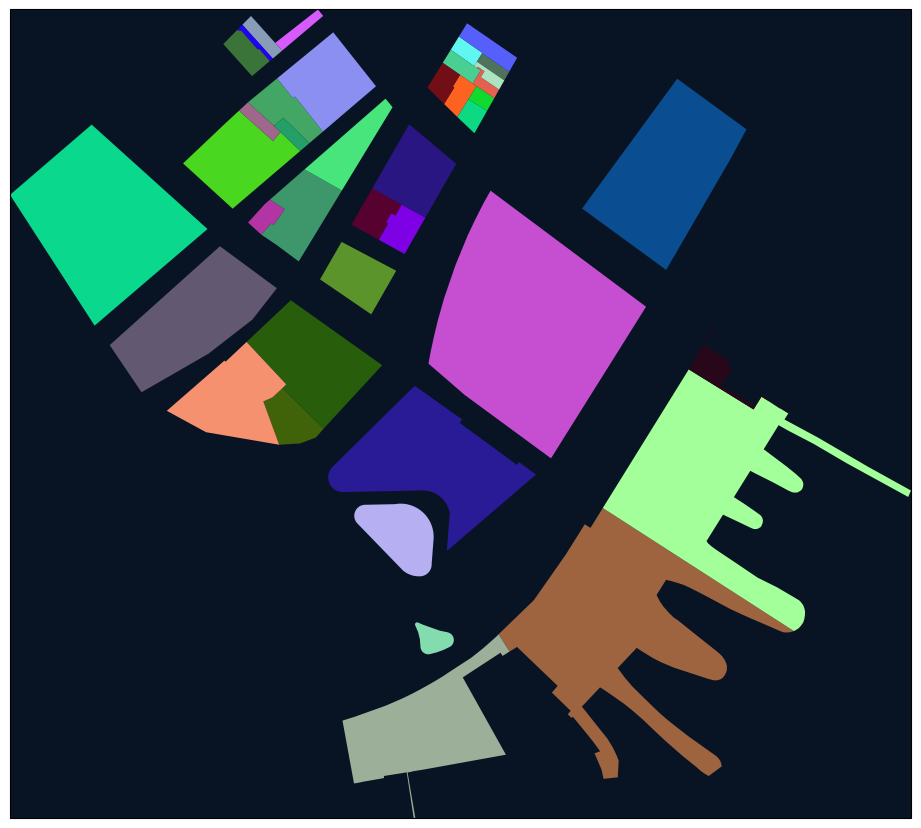

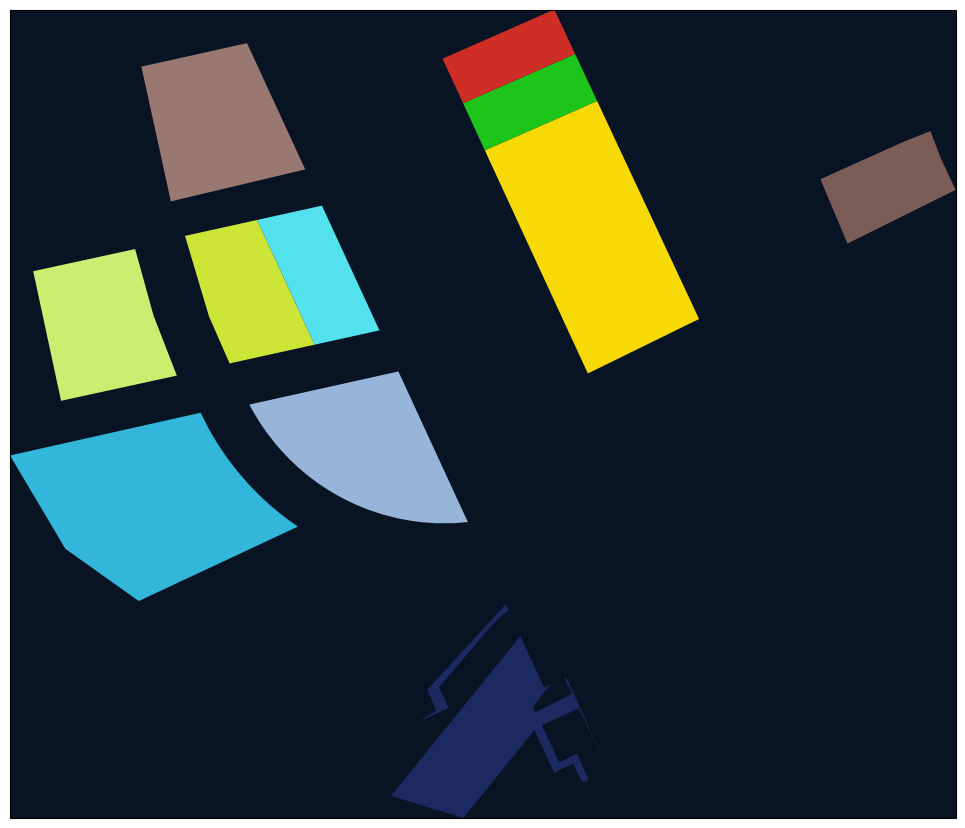

<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>


ValueError: could not broadcast input array from shape (256,256,3) into shape (256,766,3)

<Figure size 1850x1050 with 1 Axes>

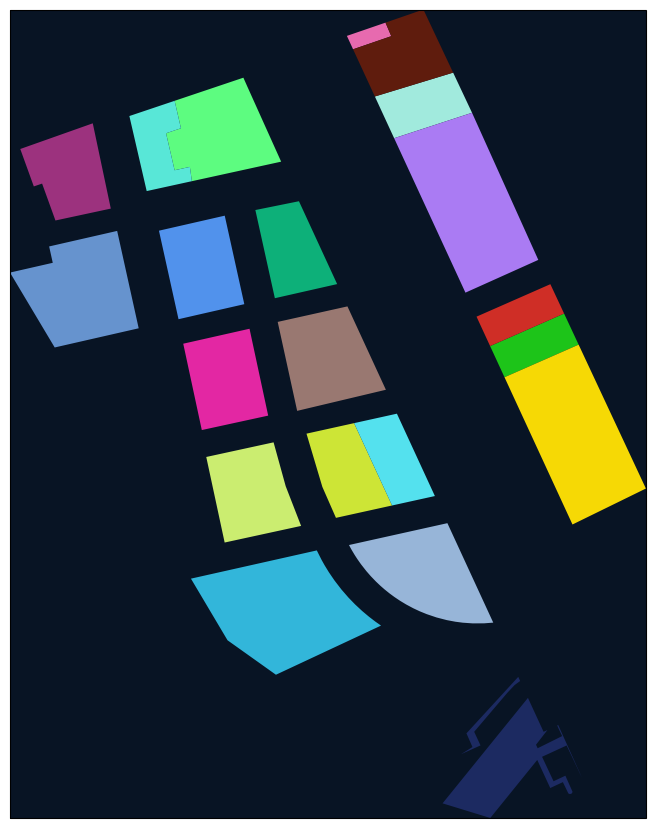

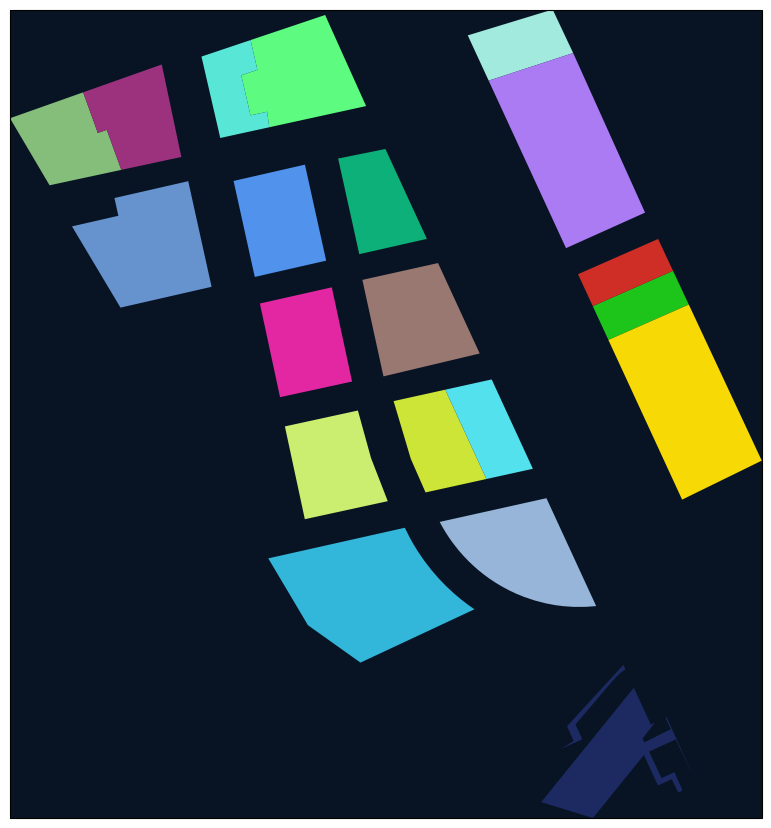

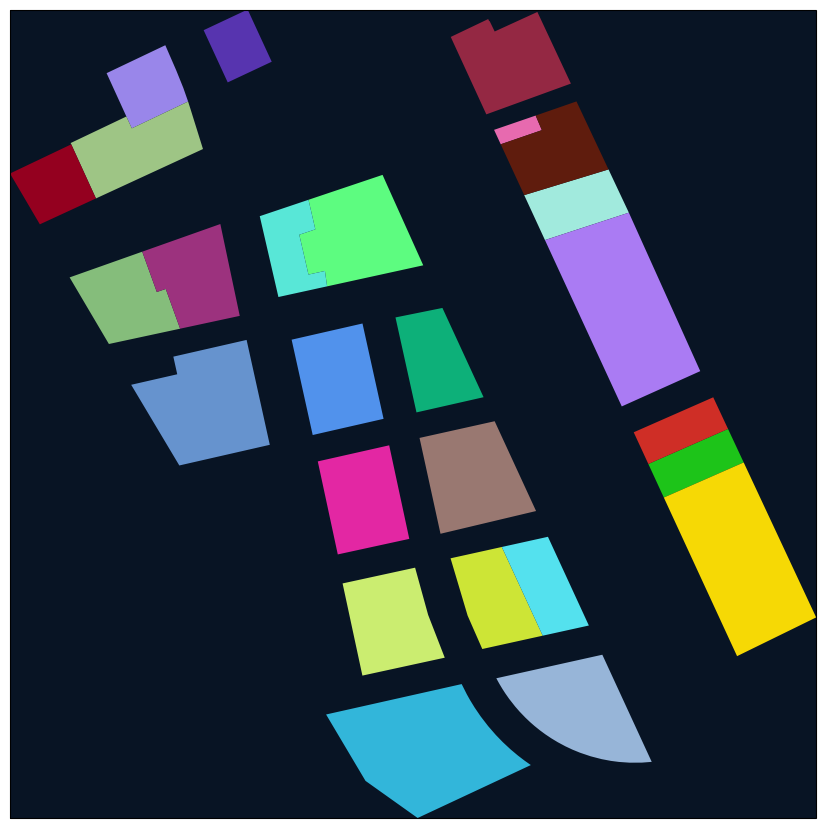

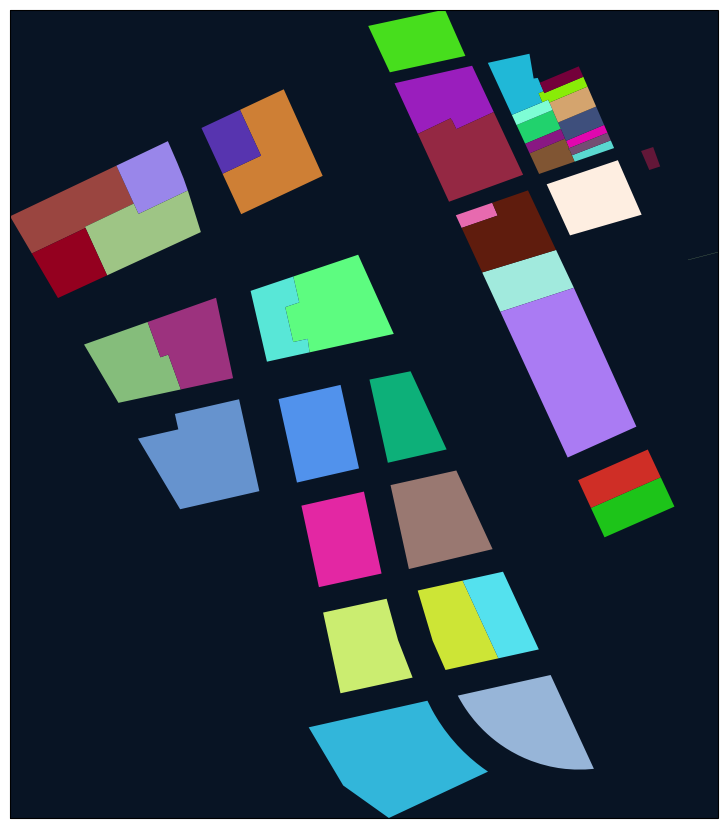

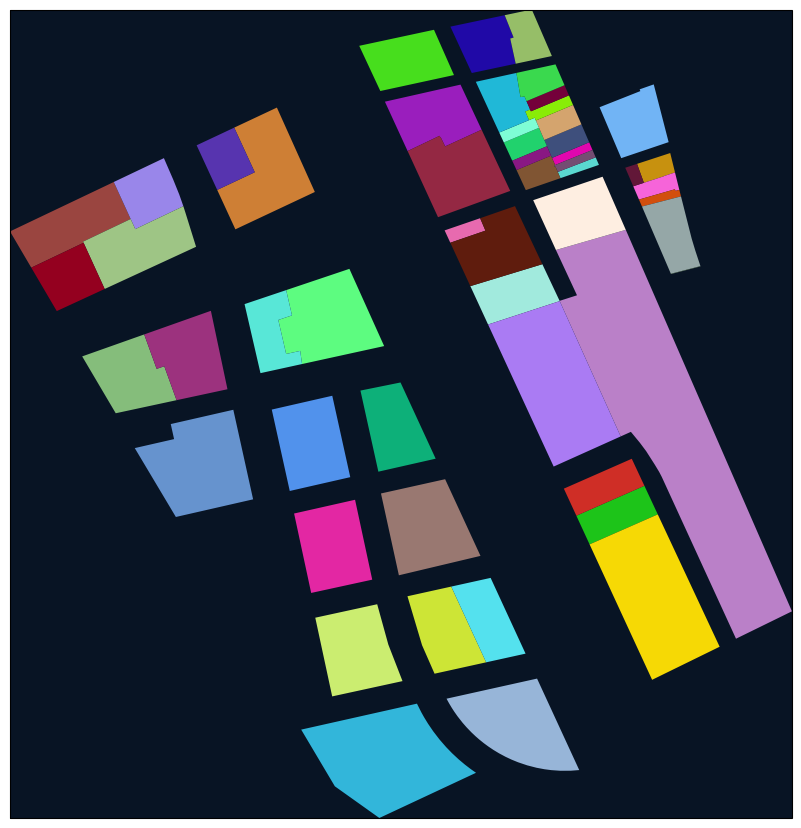

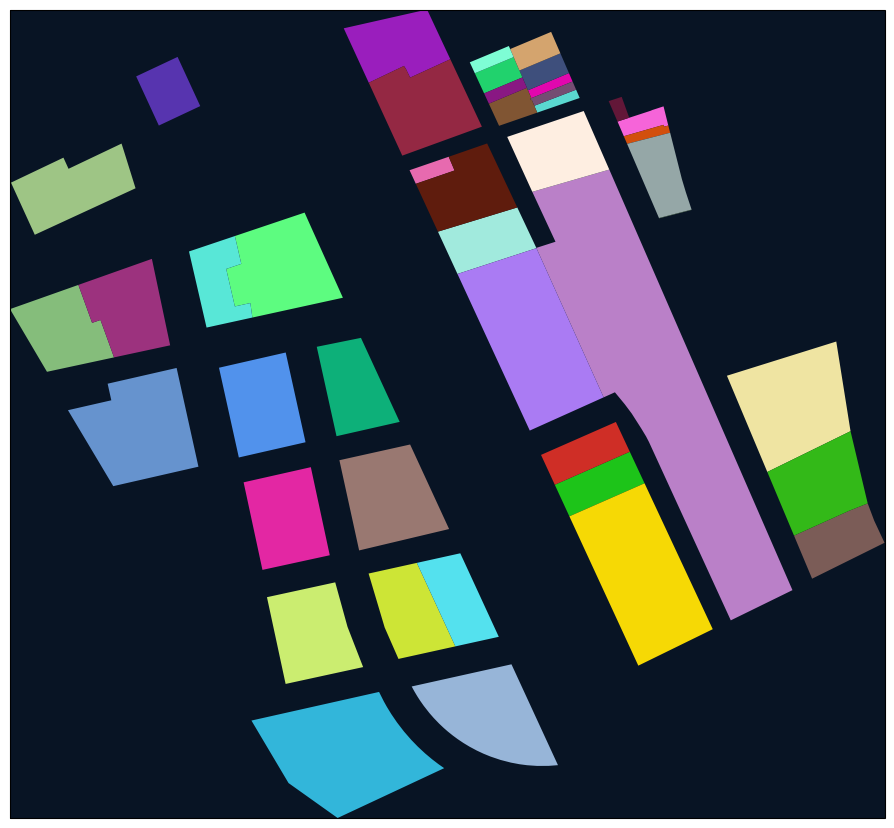

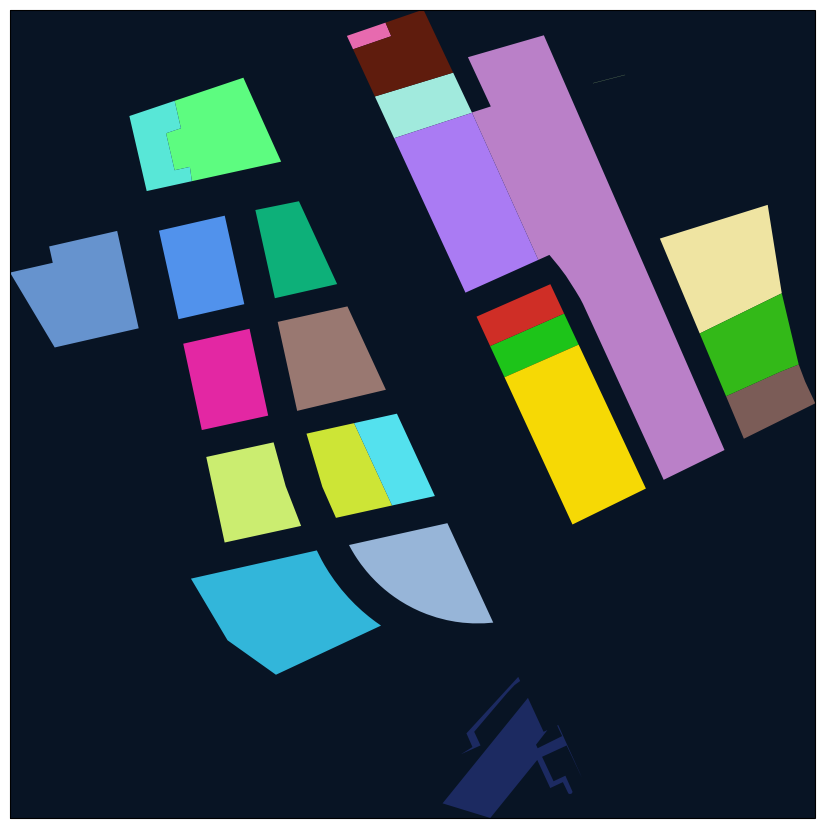

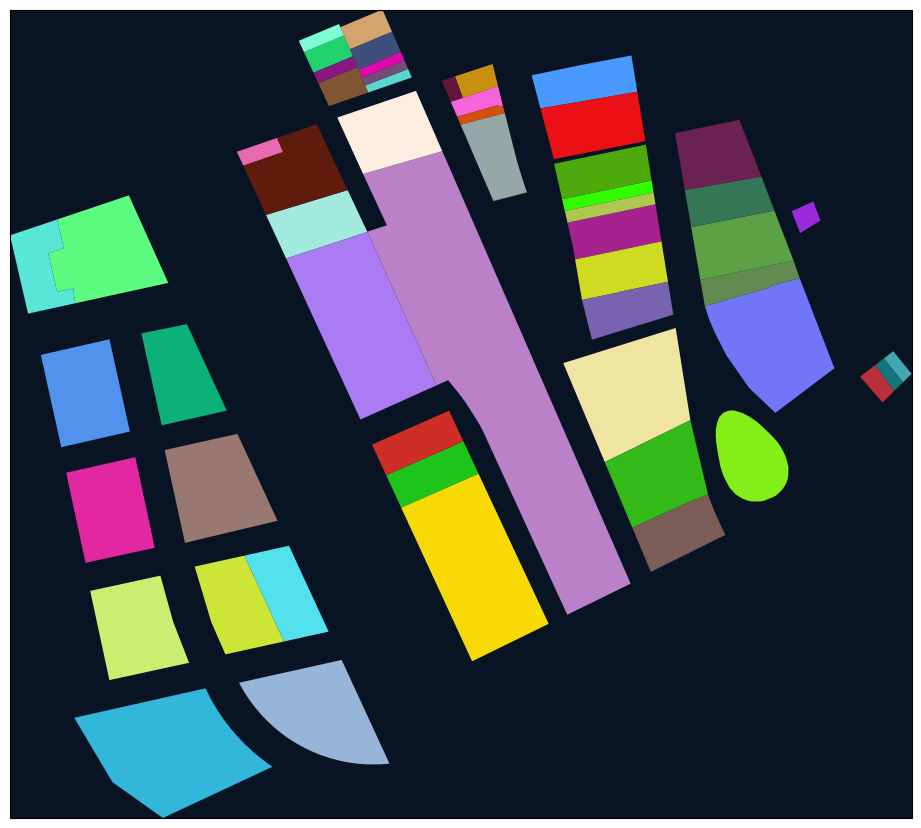

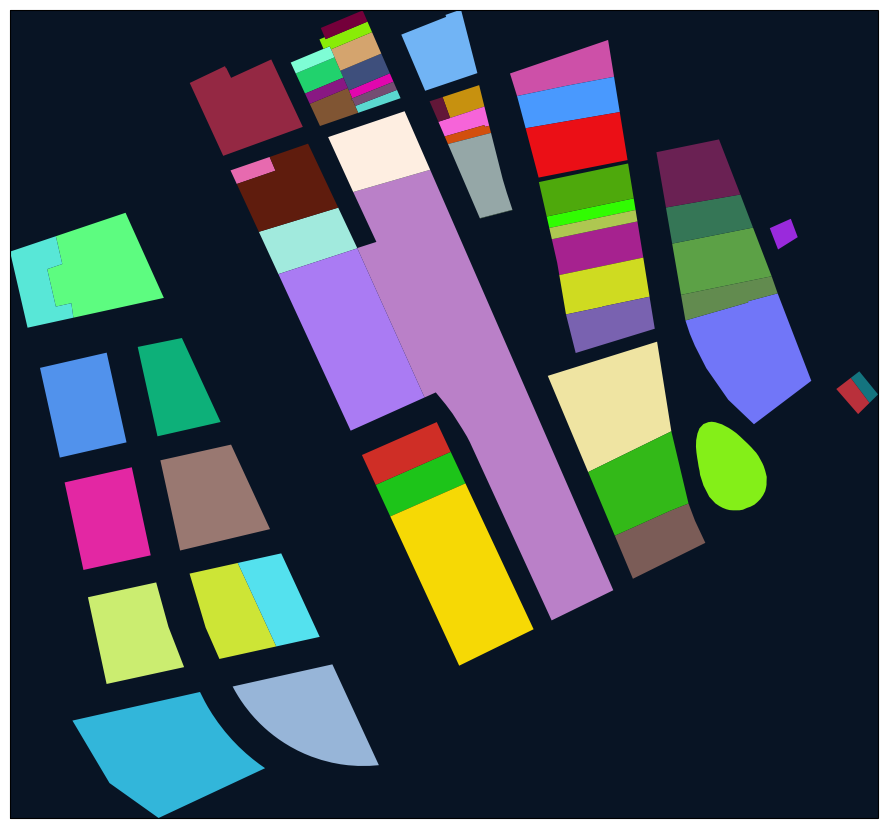

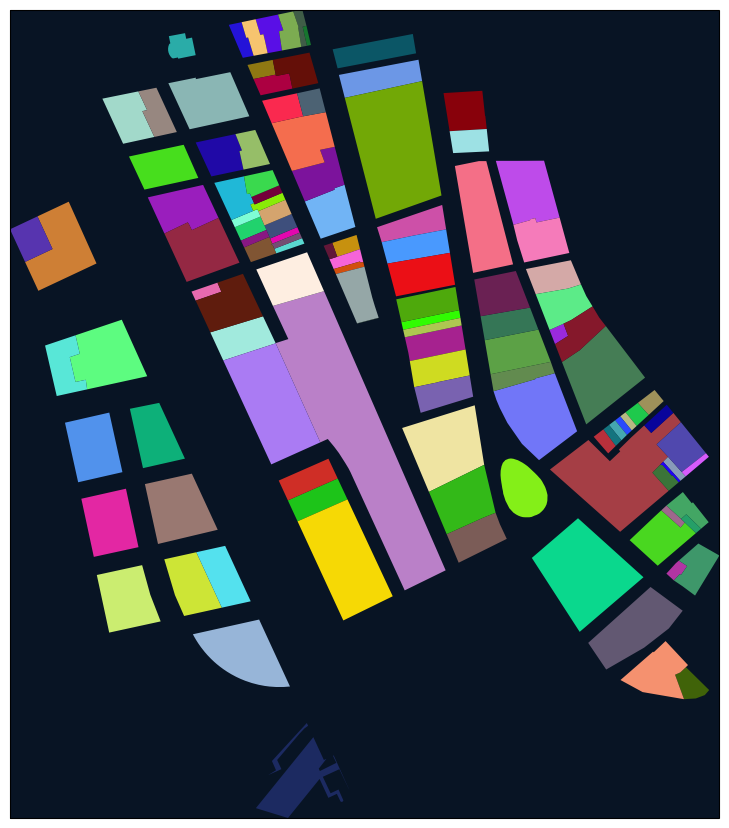

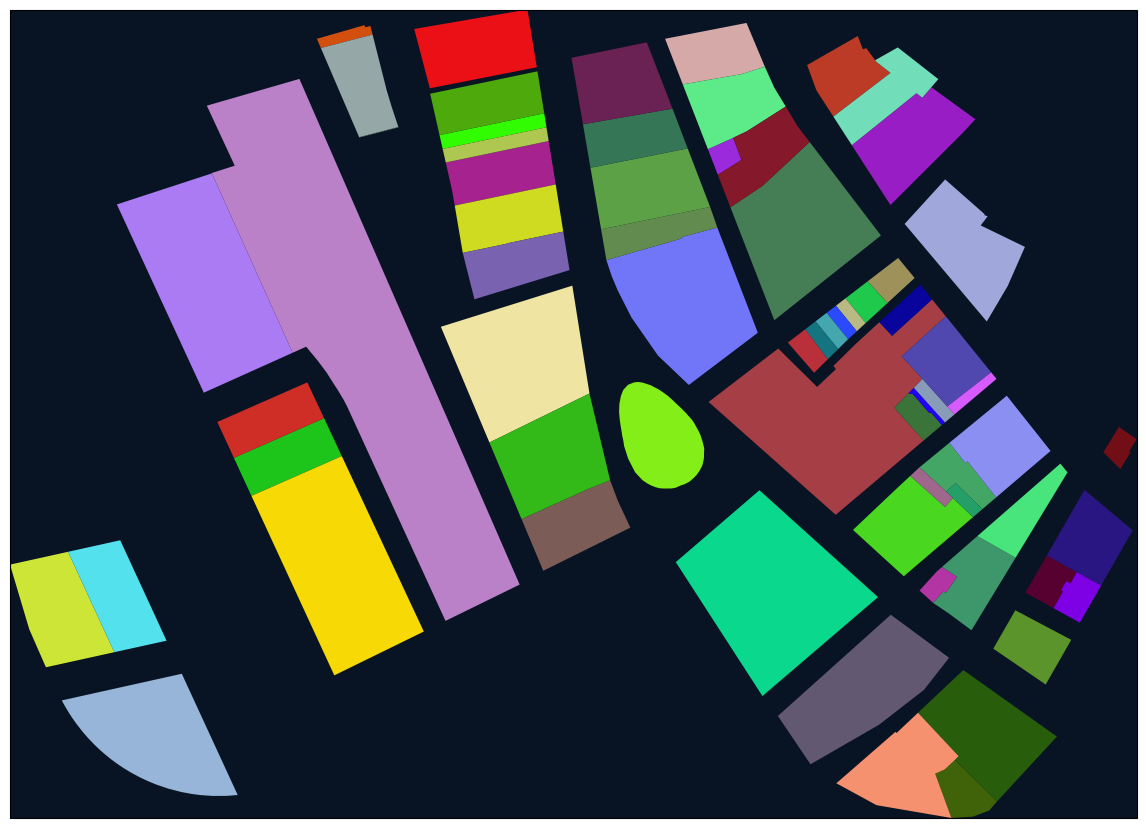

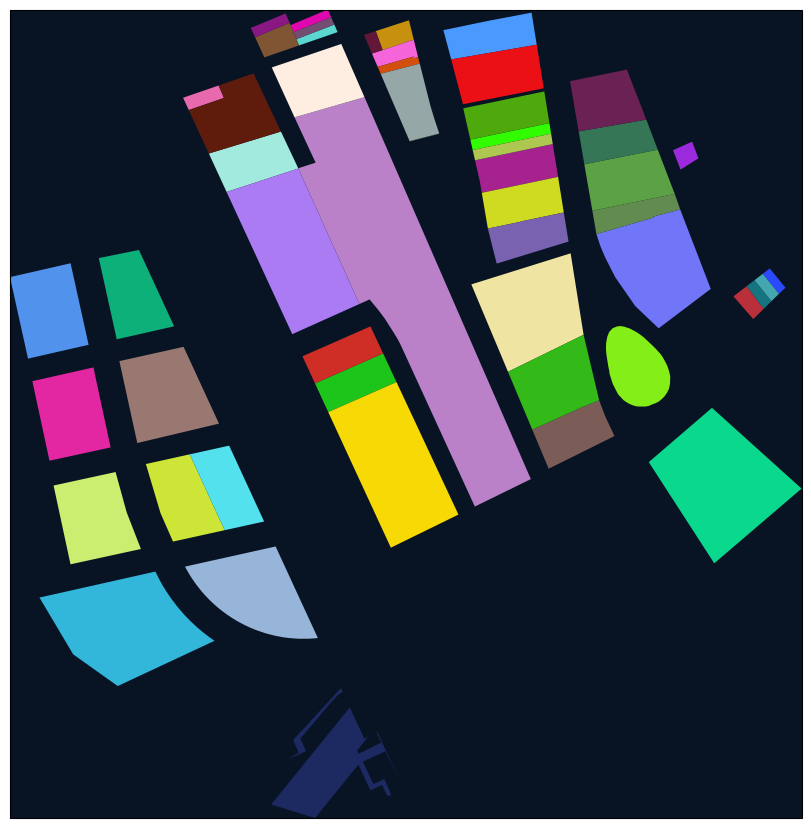

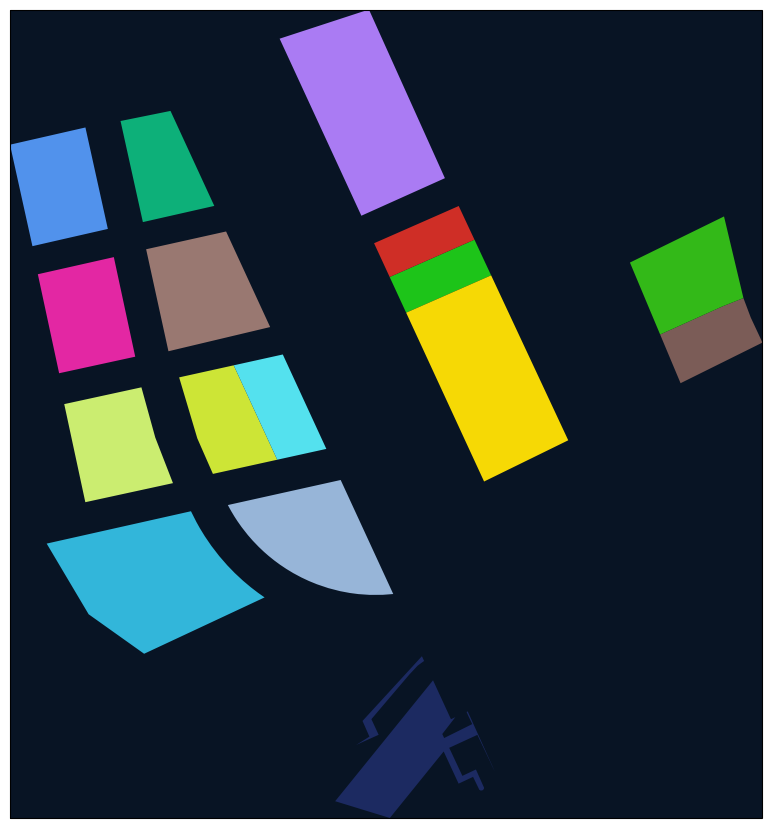

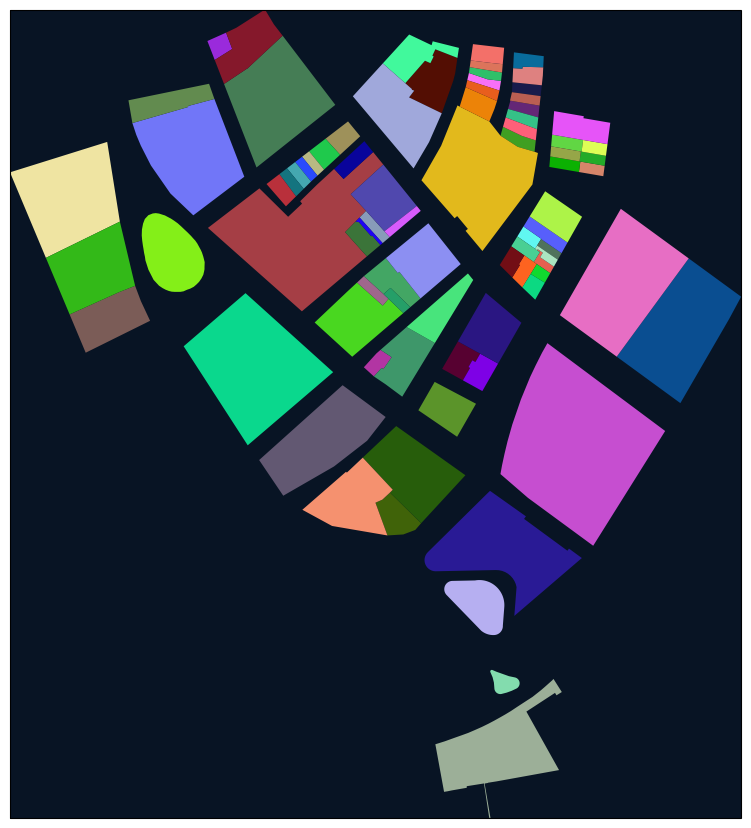

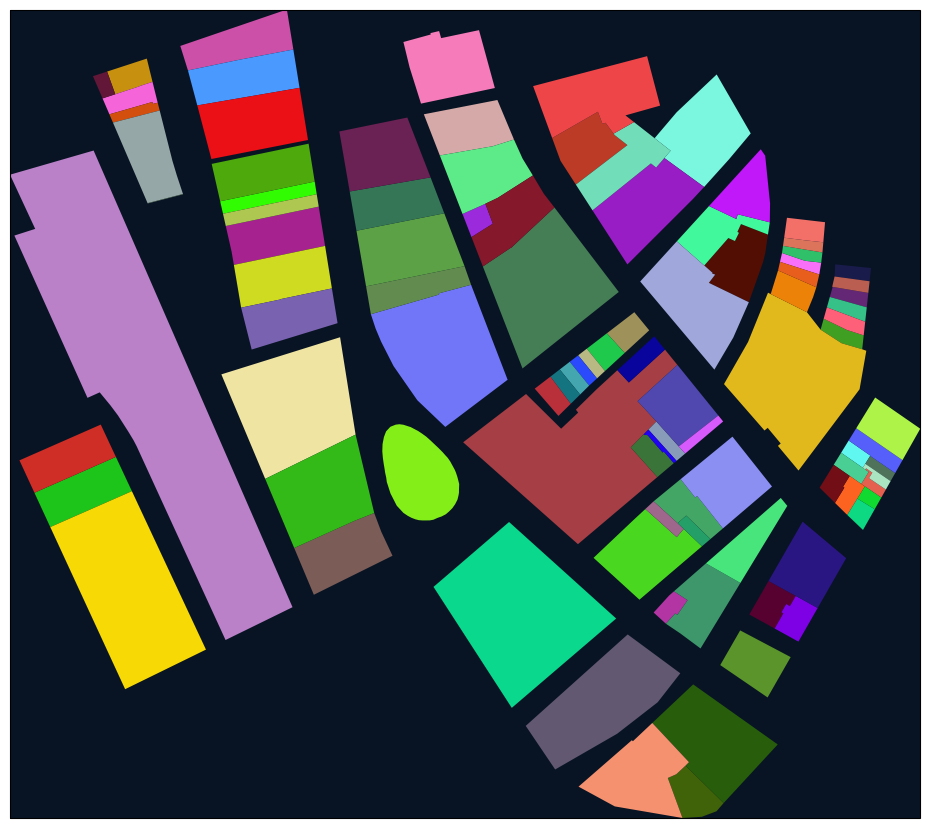

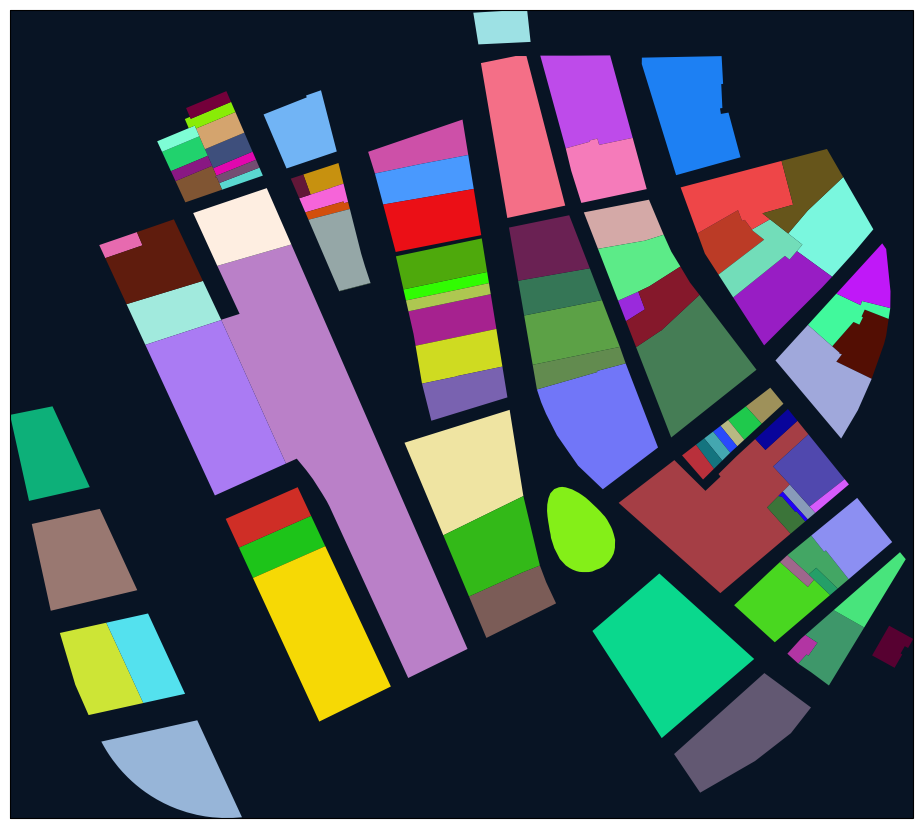

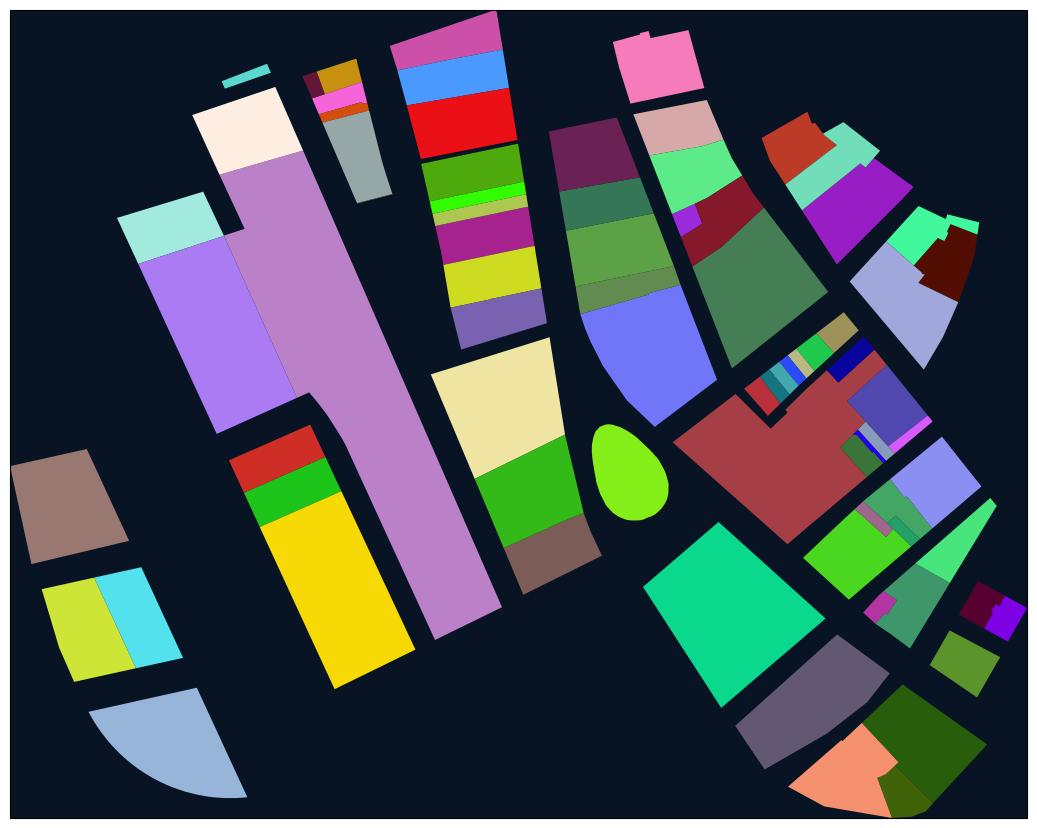

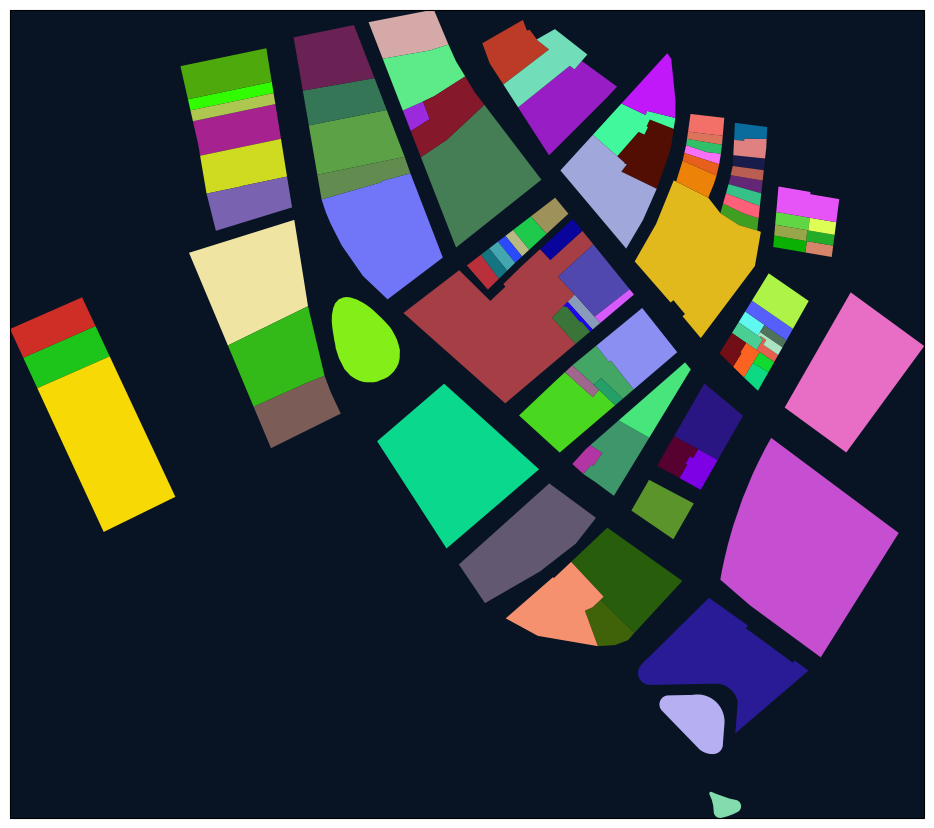

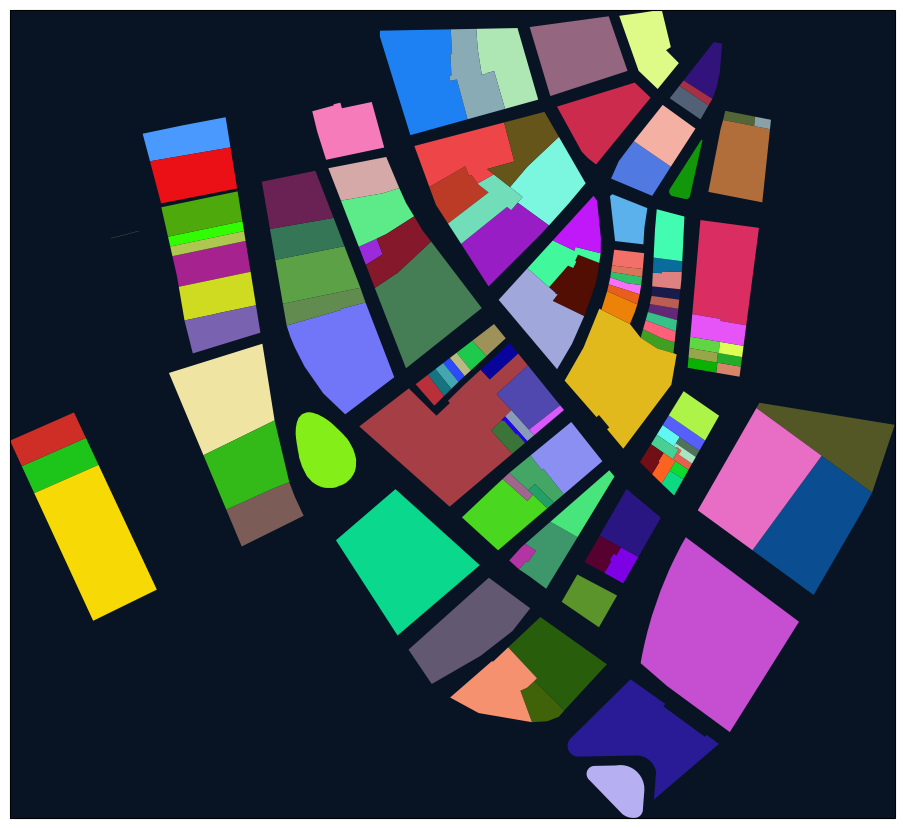

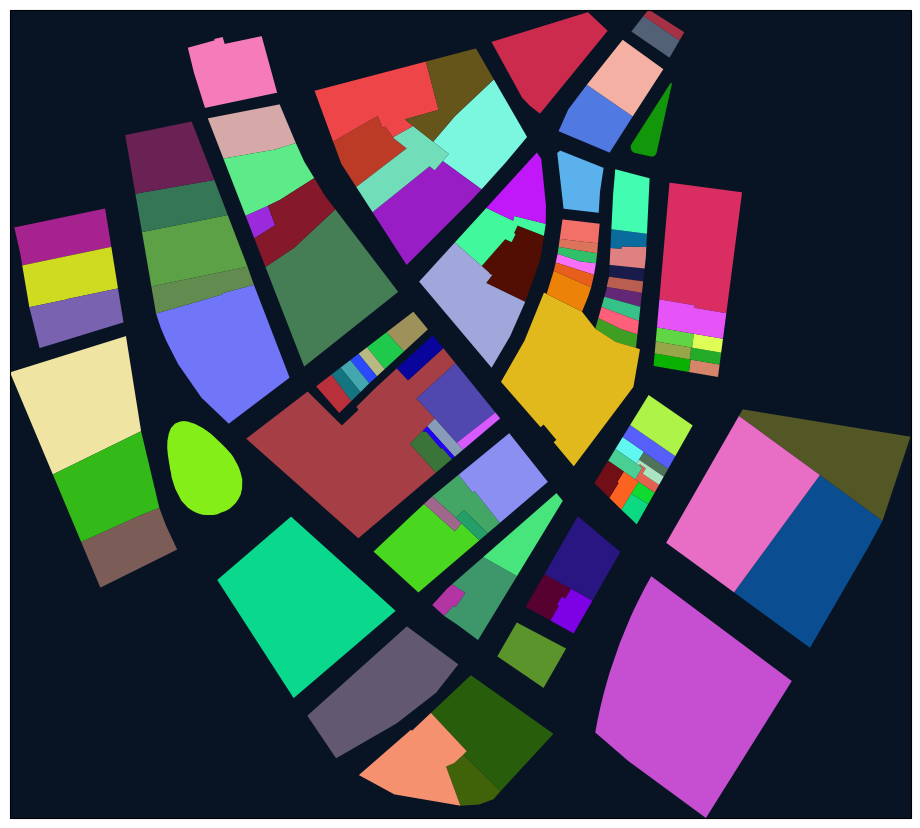

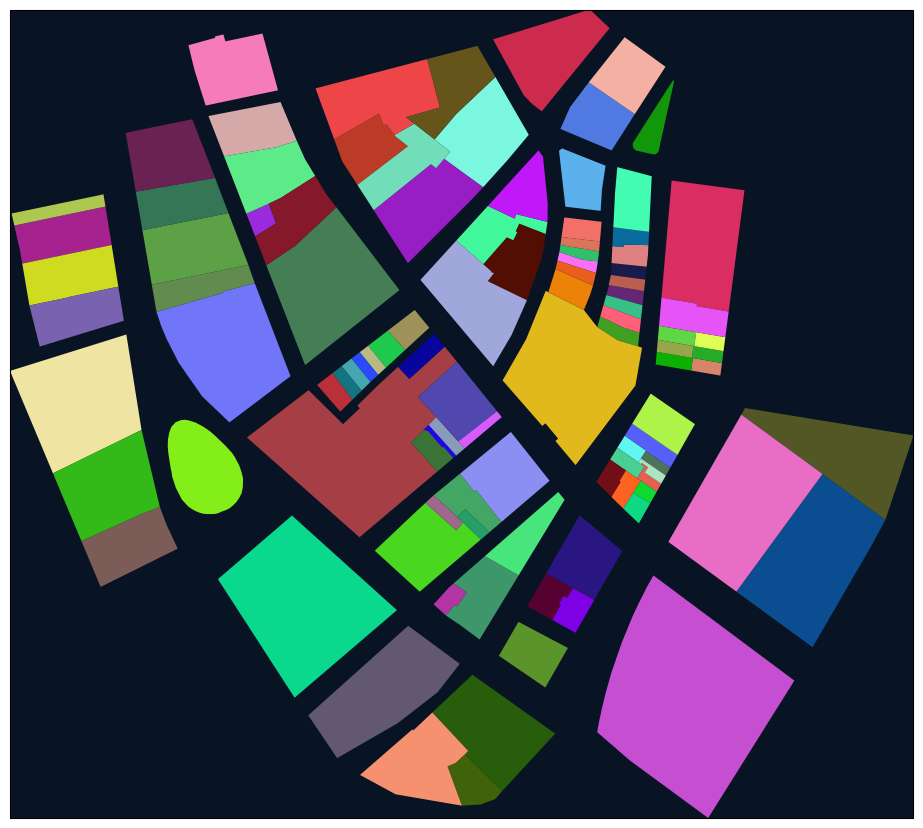

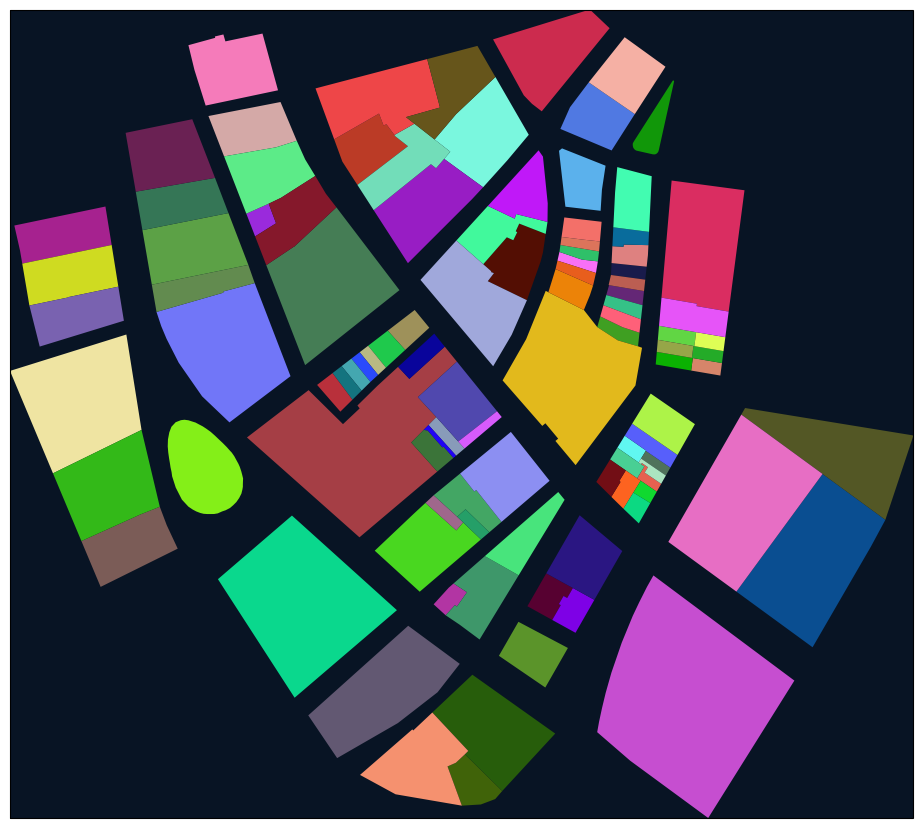

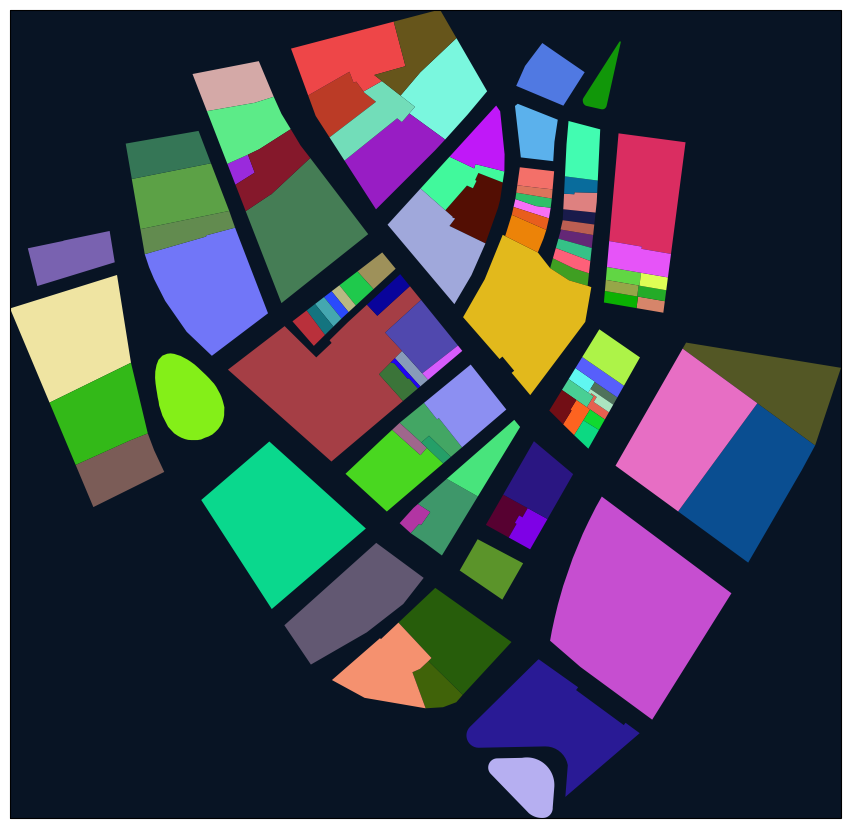

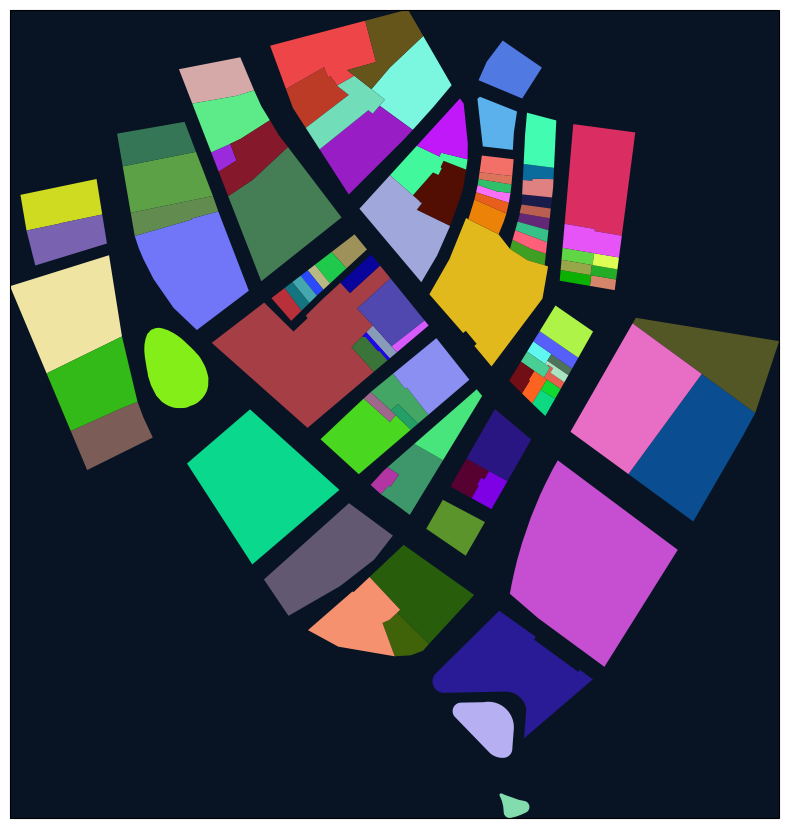

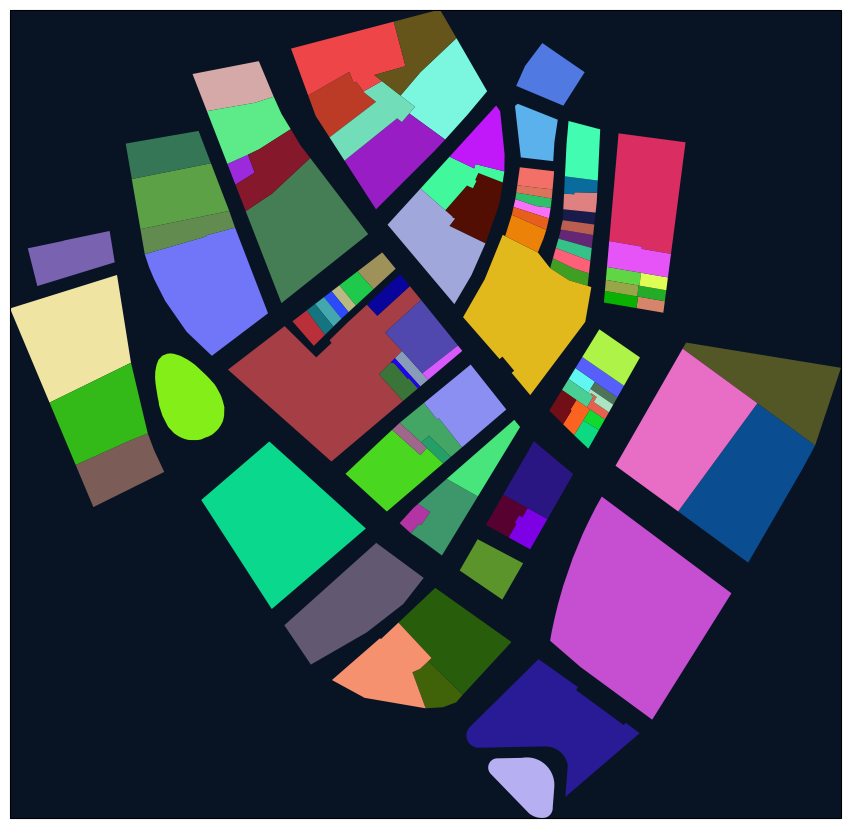

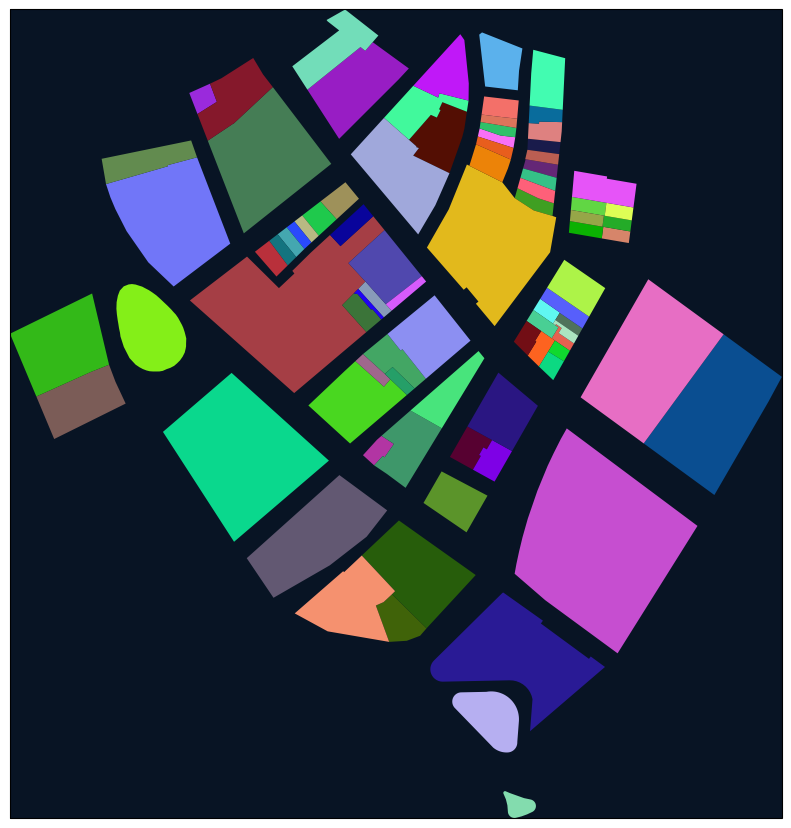

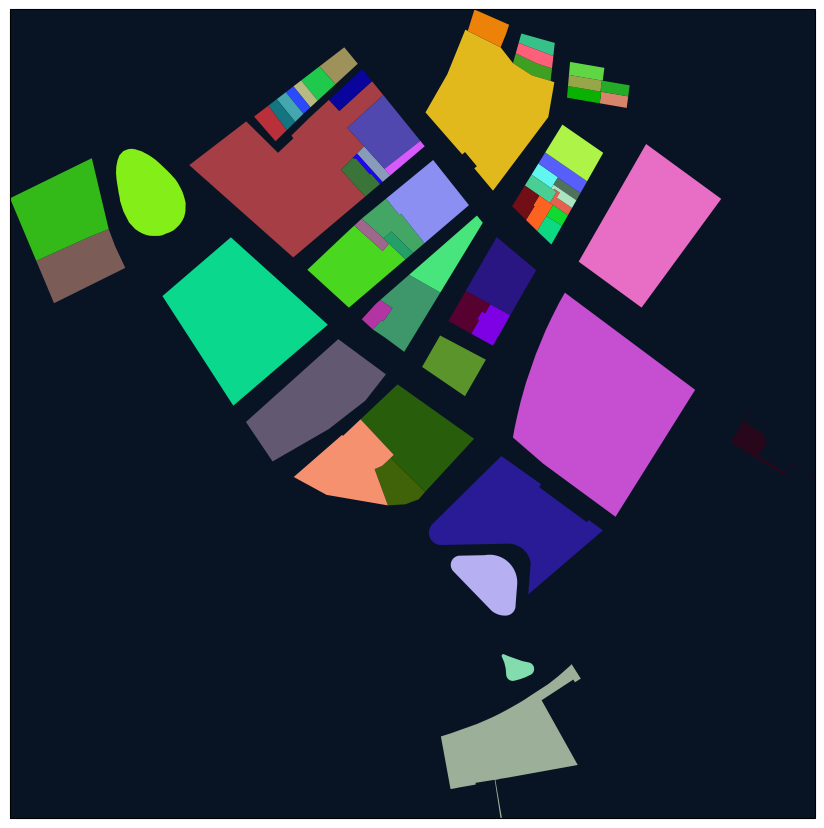

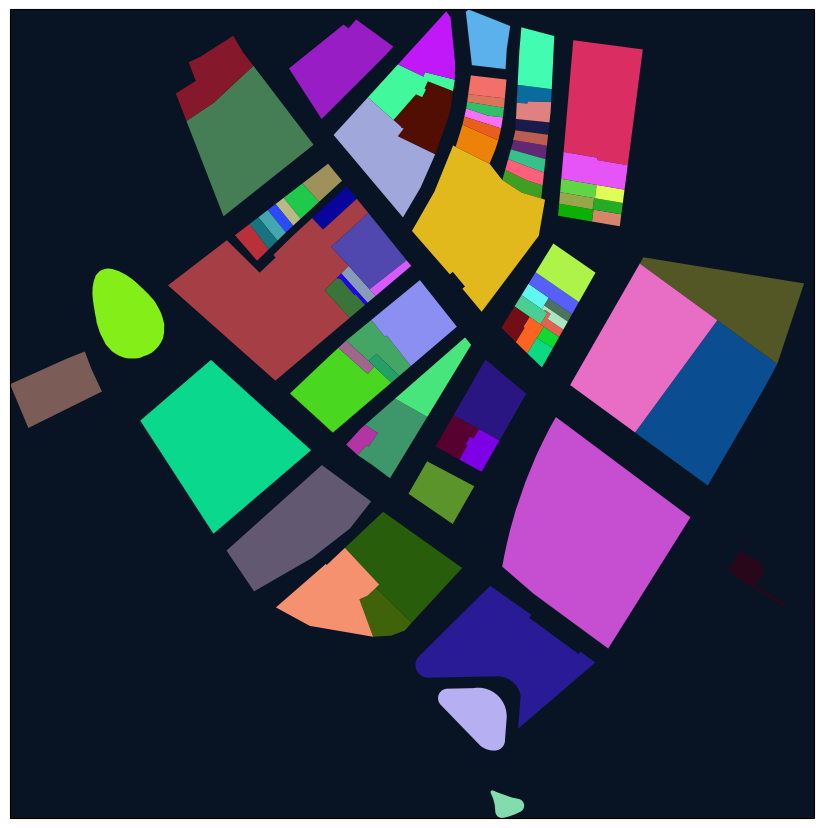

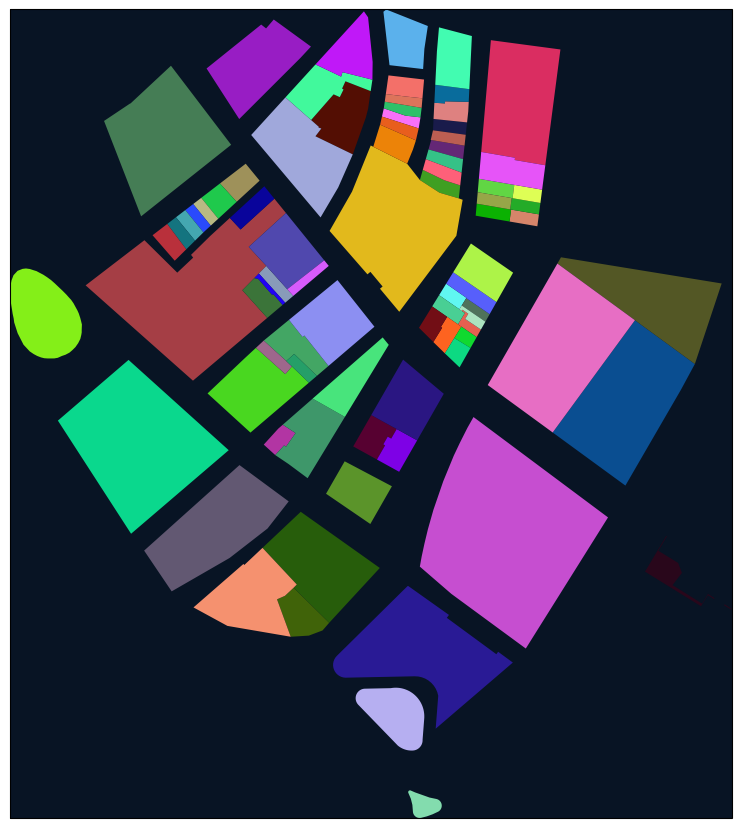

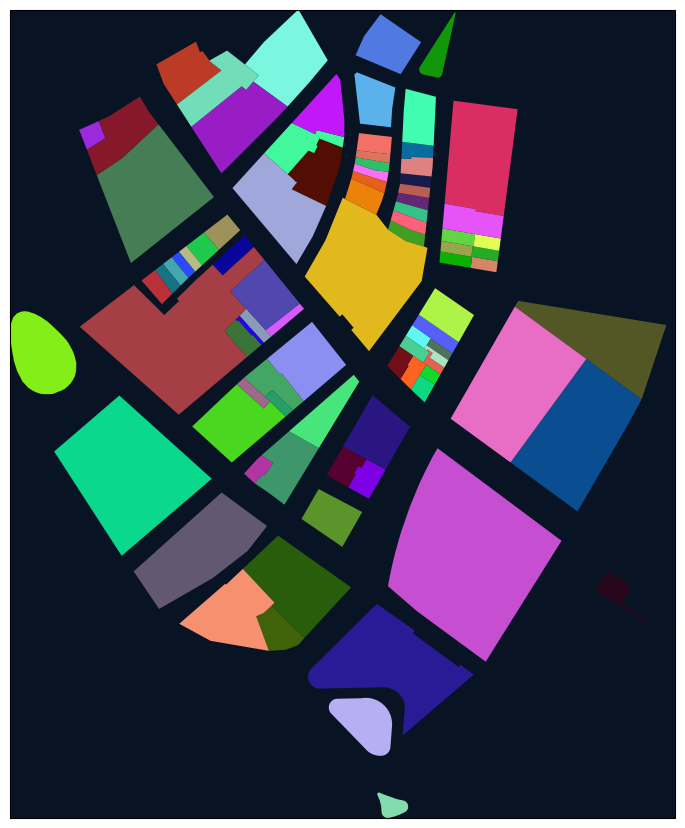

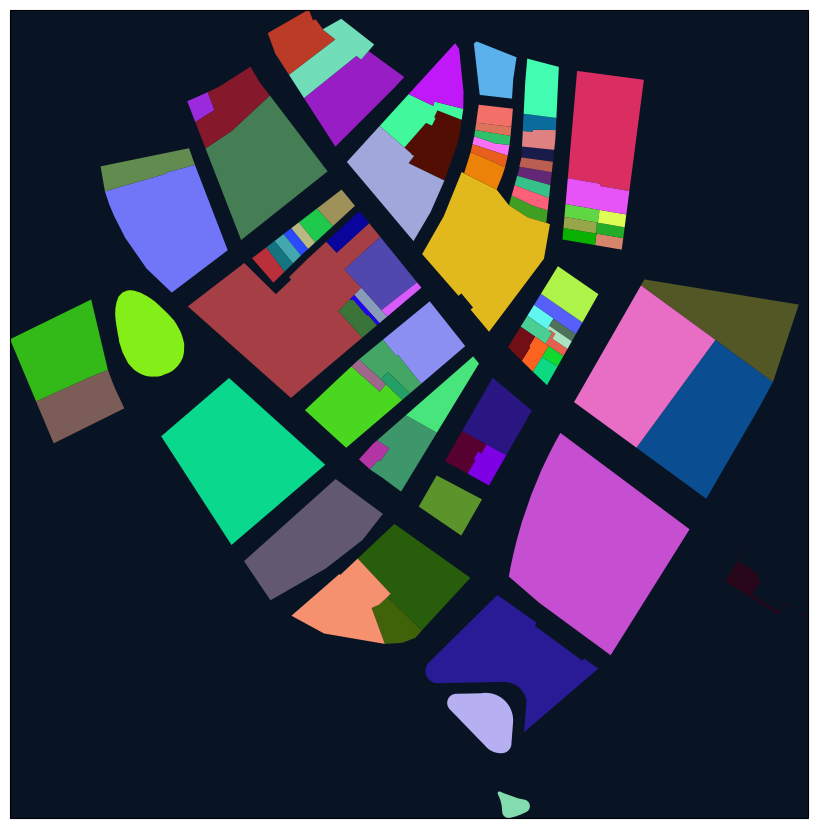

<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -3] Temporary failure in name resolution>


ValueError: could not broadcast input array from shape (256,256,3) into shape (766,766,3)

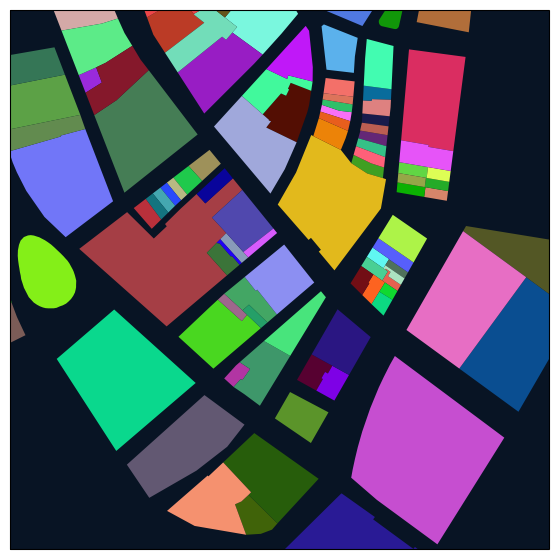

In [31]:
# create a folder to store the images
# os.mkdir('img')

# index will correspond to each of the parcel indices in the data frame. 
for i in range (0, 9999):
    subset_features = subset(df_parcels, df_buildings, i, 200)
    map_maker(subset_features[0], subset_features[1], subset_features[2], i, 18)
